In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No EMA CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


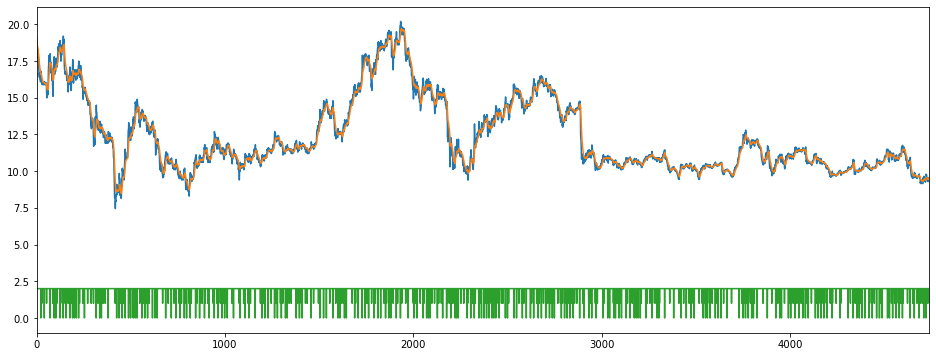

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4725, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4725, 15, 1)

In [11]:
#ema_data = np.array(#ema_data)
#ema_data.shape

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4725, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4725, 64, 64, 1)

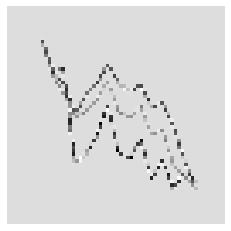

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.6084 - accuracy: 0.6484 - mse: 5.5972 - weighted_accuracy: 0.3063 - weighted_mse: 6.1065WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 23ms/step - loss: 0.2525 - accuracy: 0.3950 - mse: 1.7051 - weighted_accuracy: 0.3634 - weighted_mse: 1.7684 - val_loss: 0.2349 - val_accuracy: 0.0455 - val_mse: 0.8439 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.8439
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.1765 - mse: 1.2473 - weighted_accuracy: 0.3487 - weighted_mse: 1.2213 - val_loss: 0.2027 - val_accuracy: 0.0455 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1984 - accuracy: 0.2653 - mse: 1.1962 - weighted_accuracy: 0.3641 - weighted_mse: 1.1816 - val_loss: 0.1968 - val_accuracy: 0.0995 - val_mse: 0.9037 - val_weighted_accuracy: 0.0995 - val_weighted_mse: 0.9037
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1959 - accuracy: 0.3124 - mse: 1.2047 - weighted_accuracy: 0.3719 - weighted_mse: 1.2062 - val_loss: 0.2040 - val_accuracy: 0.0698 - val_mse: 0.9131 - val_weighted_accuracy: 0.0698 - val_weighted_mse: 0.9131
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1948 - accuracy: 0.2635 - mse: 1.1896 - weighted_accuracy: 0.3963 - weighted_mse: 1.1876 - val_loss: 0.1952 - val_accuracy: 0.0635 - val_mse: 1.0123 - val_weighted_accuracy: 0.0635 - val_weighted_mse: 1.0123
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1937 - accuracy: 0.2611 - mse: 1.2192 - weighted_accuracy: 0.4365 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1799 - accuracy: 0.1664 - mse: 1.3205 - weighted_accuracy: 0.5148 - weighted_mse: 1.2730 - val_loss: 0.1970 - val_accuracy: 0.0677 - val_mse: 1.0445 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 1.0445
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1761 - accuracy: 0.1643 - mse: 1.2876 - weighted_accuracy: 0.5436 - weighted_mse: 1.2313 - val_loss: 0.1979 - val_accuracy: 0.0804 - val_mse: 1.0534 - val_weighted_accuracy: 0.0804 - val_weighted_mse: 1.0534
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1781 - accuracy: 0.1500 - mse: 1.3105 - weighted_accuracy: 0.5145 - weighted_mse: 1.2775 - val_loss: 0.1984 - val_accuracy: 0.0741 - val_mse: 1.0379 - val_weighted_accuracy: 0.0741 - val_weighted_mse: 1.0379
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1770 - accuracy: 0.1537 - mse: 1.2554 - weighted_accuracy: 0.5250 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.1667 - mse: 1.4467 - weighted_accuracy: 0.5927 - weighted_mse: 1.4170 - val_loss: 0.1991 - val_accuracy: 0.1545 - val_mse: 1.2486 - val_weighted_accuracy: 0.1545 - val_weighted_mse: 1.2486
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1608 - accuracy: 0.1579 - mse: 1.4048 - weighted_accuracy: 0.5858 - weighted_mse: 1.3783 - val_loss: 0.1982 - val_accuracy: 0.1291 - val_mse: 1.2517 - val_weighted_accuracy: 0.1291 - val_weighted_mse: 1.2517
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1627 - accuracy: 0.1791 - mse: 1.4703 - weighted_accuracy: 0.6176 - weighted_mse: 1.3961 - val_loss: 0.1998 - val_accuracy: 0.1270 - val_mse: 1.3042 - val_weighted_accuracy: 0.1270 - val_weighted_mse: 1.3042
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1581 - accuracy: 0.1653 - mse: 1.4590 - weighted_accuracy: 0.6107 - weig

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1427 - accuracy: 0.2458 - mse: 1.6963 - weighted_accuracy: 0.6625 - weighted_mse: 1.6752 - val_loss: 0.1959 - val_accuracy: 0.2413 - val_mse: 1.5631 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.5631
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1435 - accuracy: 0.2466 - mse: 1.7085 - weighted_accuracy: 0.6683 - weighted_mse: 1.7183 - val_loss: 0.1966 - val_accuracy: 0.2275 - val_mse: 1.4865 - val_weighted_accuracy: 0.2275 - val_weighted_mse: 1.4865
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1412 - accuracy: 0.2540 - mse: 1.6941 - weighted_accuracy: 0.6765 - weighted_mse: 1.7161 - val_loss: 0.1929 - val_accuracy: 0.2677 - val_mse: 1.4726 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.4726
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1429 - accuracy: 0.2638 - mse: 1.6927 - weighted_accuracy: 0.6783 -

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.3847 - mse: 1.9547 - weighted_accuracy: 0.7189 - weighted_mse: 2.1008 - val_loss: 0.1839 - val_accuracy: 0.3926 - val_mse: 1.7677 - val_weighted_accuracy: 0.3926 - val_weighted_mse: 1.7677
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.3614 - mse: 2.0834 - weighted_accuracy: 0.7049 - weighted_mse: 2.2323 - val_loss: 0.1822 - val_accuracy: 0.4413 - val_mse: 1.8334 - val_weighted_accuracy: 0.4413 - val_weighted_mse: 1.8334
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1275 - accuracy: 0.4013 - mse: 2.0326 - weighted_accuracy: 0.7287 - weighted_mse: 2.2454 - val_loss: 0.1851 - val_accuracy: 0.3810 - val_mse: 1.7582 - val_weighted_accuracy: 0.3810 - val_weighted_mse: 1.7582
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1264 - accuracy: 0.3902 - mse: 2.1110 - weighted_accuracy: 0.7321 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.5397 - mse: 2.4760 - weighted_accuracy: 0.7682 - weighted_mse: 2.9968 - val_loss: 0.1672 - val_accuracy: 0.5418 - val_mse: 1.9870 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.9870
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 0.5415 - mse: 2.5172 - weighted_accuracy: 0.7894 - weighted_mse: 3.1189 - val_loss: 0.1630 - val_accuracy: 0.5894 - val_mse: 2.2253 - val_weighted_accuracy: 0.5894 - val_weighted_mse: 2.2253
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1168 - accuracy: 0.5344 - mse: 2.4370 - weighted_accuracy: 0.7627 - weighted_mse: 2.9511 - val_loss: 0.1669 - val_accuracy: 0.5598 - val_mse: 2.1501 - val_weighted_accuracy: 0.5598 - val_weighted_mse: 2.1501
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1146 - accuracy: 0.5542 - mse: 2.4772 - weighted_accuracy: 0.7867 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14955364167690277
Test accuracy: 0.6634920835494995


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.17831013 -2.9674172  -0.76378465]
 [-1.0419176  -1.4784429  -0.35342324]
 [-3.3102384  -0.16983138 -0.58874565]
 ...
 [-2.4086313  -0.6032351  -0.35895827]
 [-1.640841   -1.3266319  -0.39098036]
 [-2.571352   -0.9379386  -0.27835754]]


Counter({0: 104, 2: 679, 1: 162})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 945
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 33
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 35
actual holds but predicted buy: 150
actual holds but predicted sell: 98
actual predicted holds: 611
Percentage buys correct: 23.25581395348837%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 71.12922002328288%
actual buys: 43
actual sells: 43
actual holds: 859


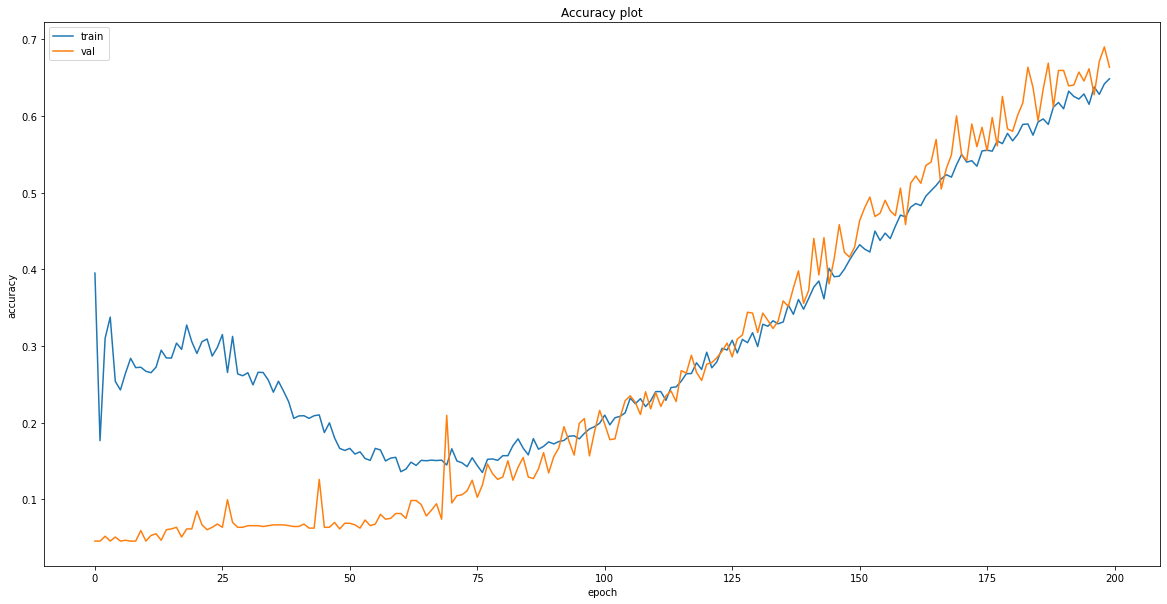

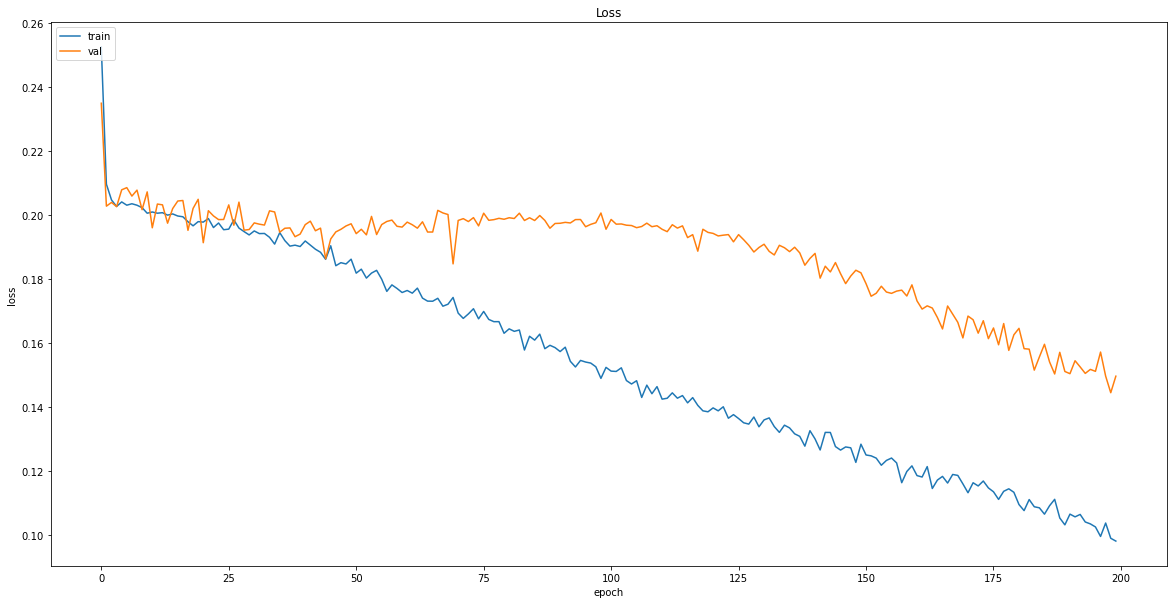

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_no_ema.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


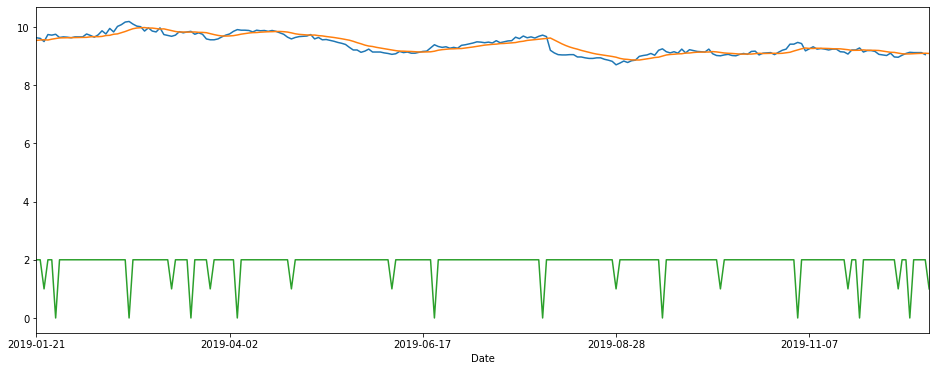

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [32]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [34]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1436 - accuracy: 0.7294 - mean_squared_error: 2.6836 - weighted_accuracy: 0.7294 - weighted_mean_squared_error: 2.6836
Test loss: 0.14361156523227692
Test accuracy: 0.7293577790260315


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 165, 0: 17, 1: 36})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [39]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [40]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            0   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

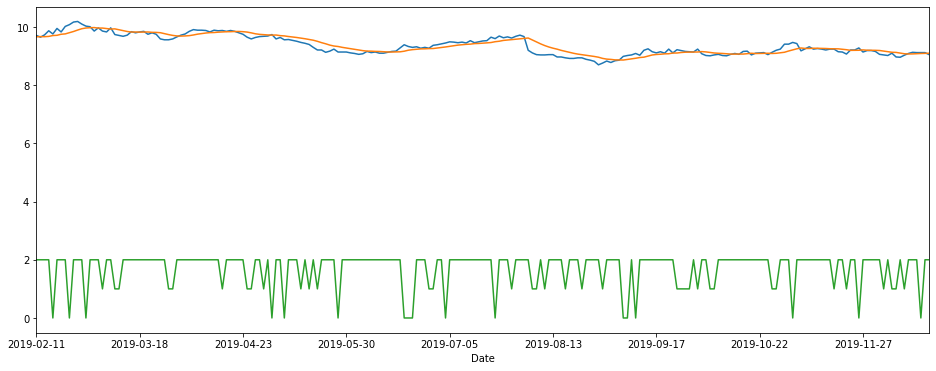

In [41]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

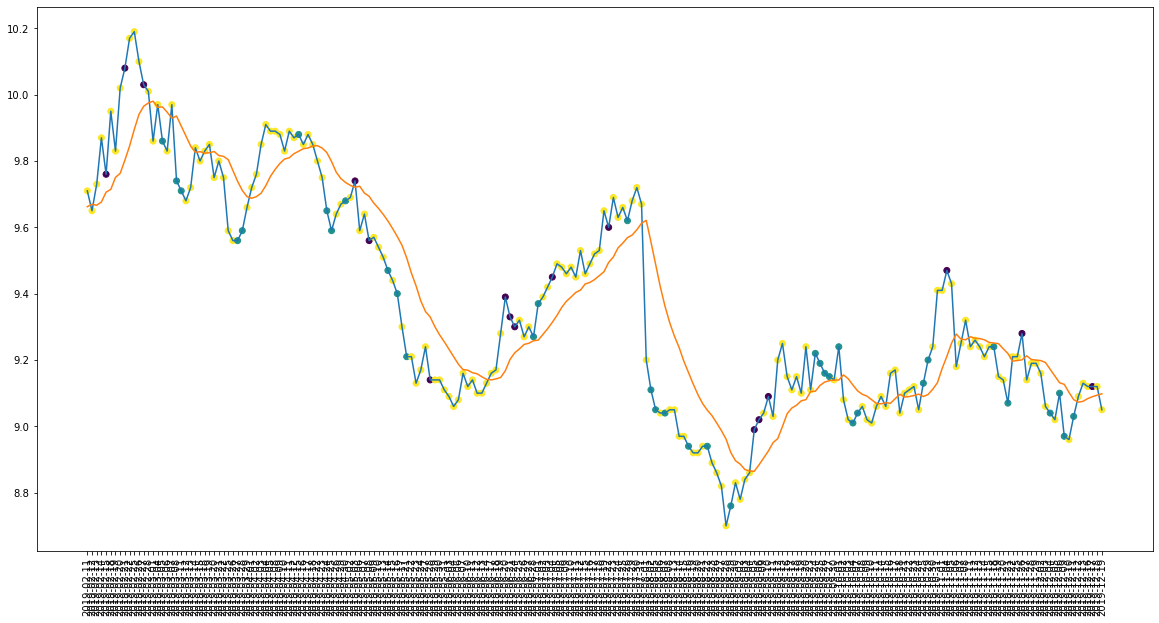

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

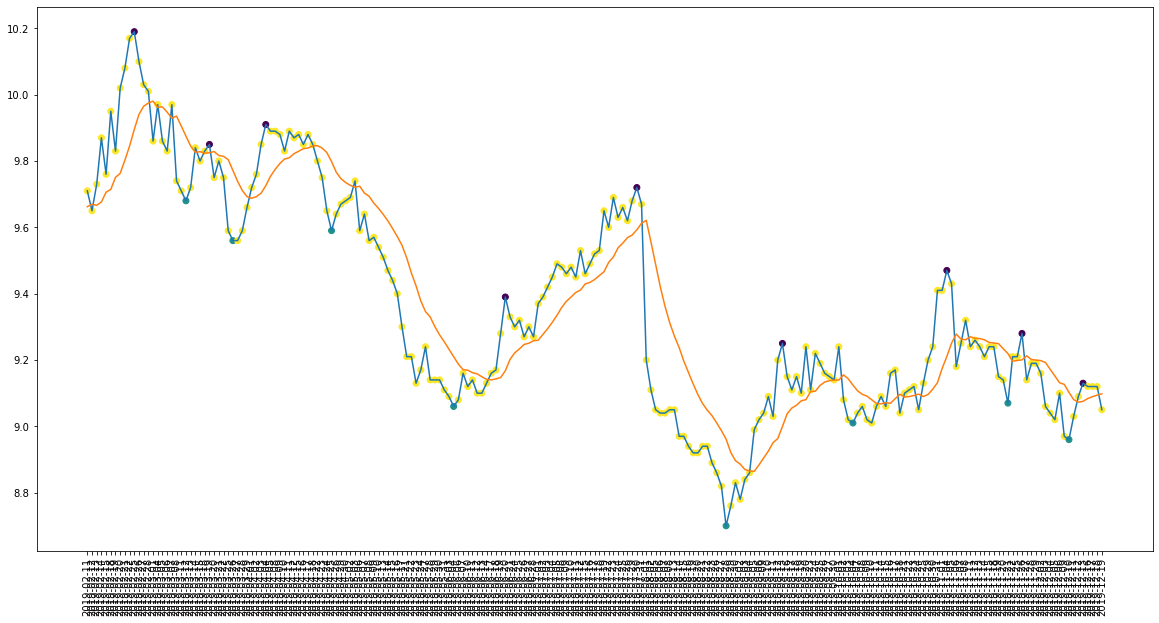

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [44]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 33
actual holds but predicted sell: 14
actual predicted holds: 153
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 76.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [45]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 52.77777777777778%
Percentage sells correct: 58.8235294117647%
Percentage holds correct: 79.8780487804878%


In [46]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.859999656677246
Shares owned at the moment: 1011
Cash capital at the moment: $4.1270830538269365


Stop Loss Activated!

Share price: $9.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9672.954639395952


Share price: $9.5600004196167
Shares owned at the moment: 1009
Cash capital at the moment: $0.38760483836995263


Stop Loss Activated!

Share price: $9.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9267.722195722818


Share price: $9.210000038146973
Shares owned at the moment: 1003
Cash capital at the moment: $4.688674856184662


Stop Loss Activated!

Share price: $8.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $8946.849500138043


Share price: $8.9399995803833
Shares owned at the moment: 998
Cash capital at the moment: $0.19409006714704446


Price increase from previously bought: 5.637915324827025%
Share price: $9.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: 

In [47]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


In [48]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells correct_holds  \
0       0.729358  33.333333333333336%  33.333333333333336%         76.5%   

     correct_low_buys correct_high_sells  correct_mid_holds  \
0  52.77777777777778%  58.8235294117647%  79.8780487804878%   

         Profit gained   buy_n_hold profit  
0  -8.694745558424039%  -7.30802773938658%

### Recession

In [49]:
logger = []

In [50]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


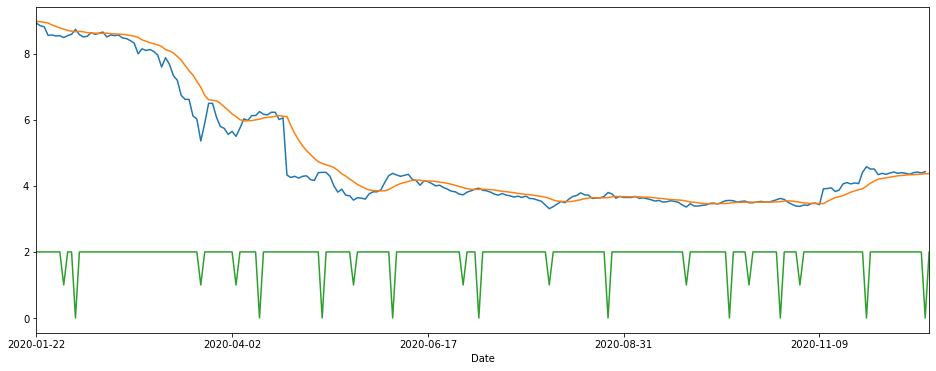

In [51]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [52]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 6ms/step - loss: 0.1486 - accuracy: 0.6930 - mean_squared_error: 2.8297 - weighted_accuracy: 0.6930 - weighted_mean_squared_error: 2.8297
Test loss: 0.14855346083641052
Test accuracy: 0.6930232644081116


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 154, 0: 20, 1: 41})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [60]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [61]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            0   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

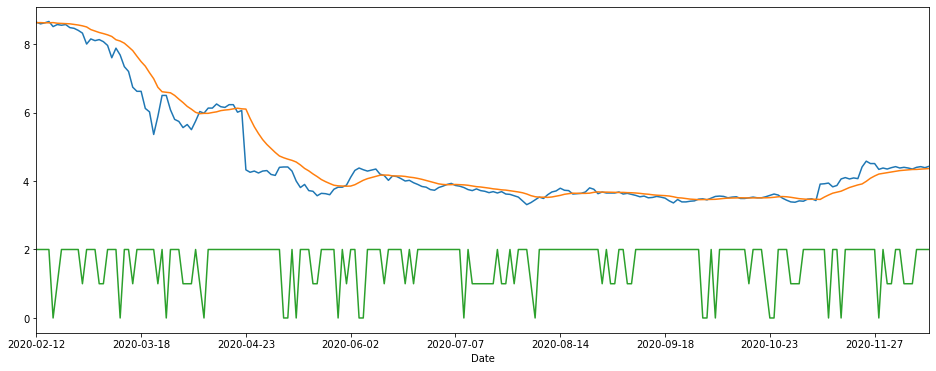

In [62]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

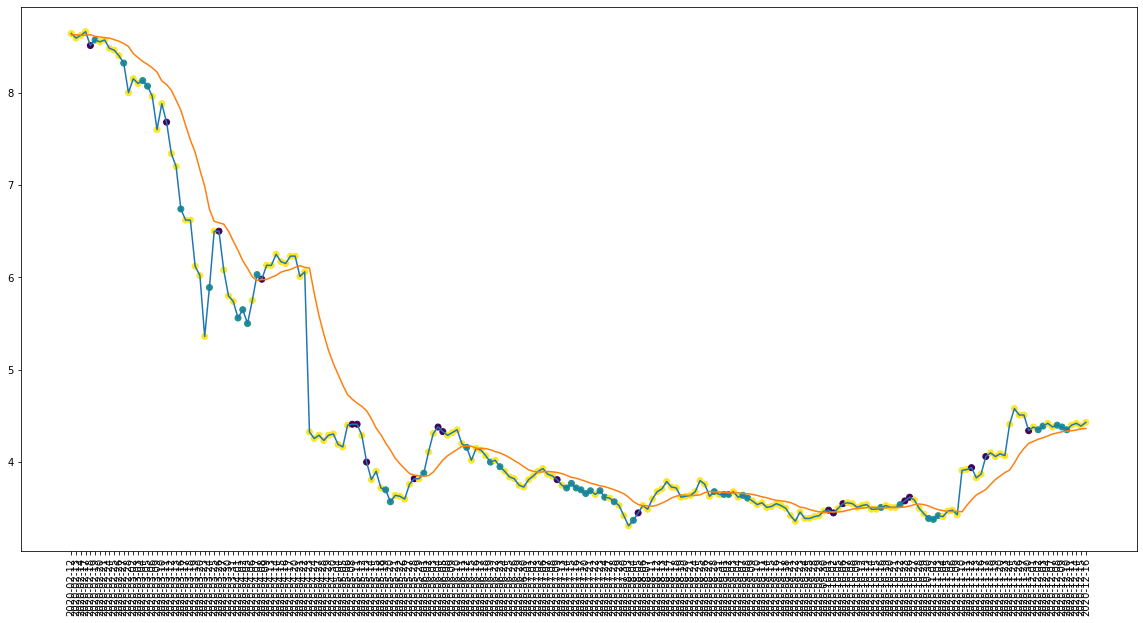

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

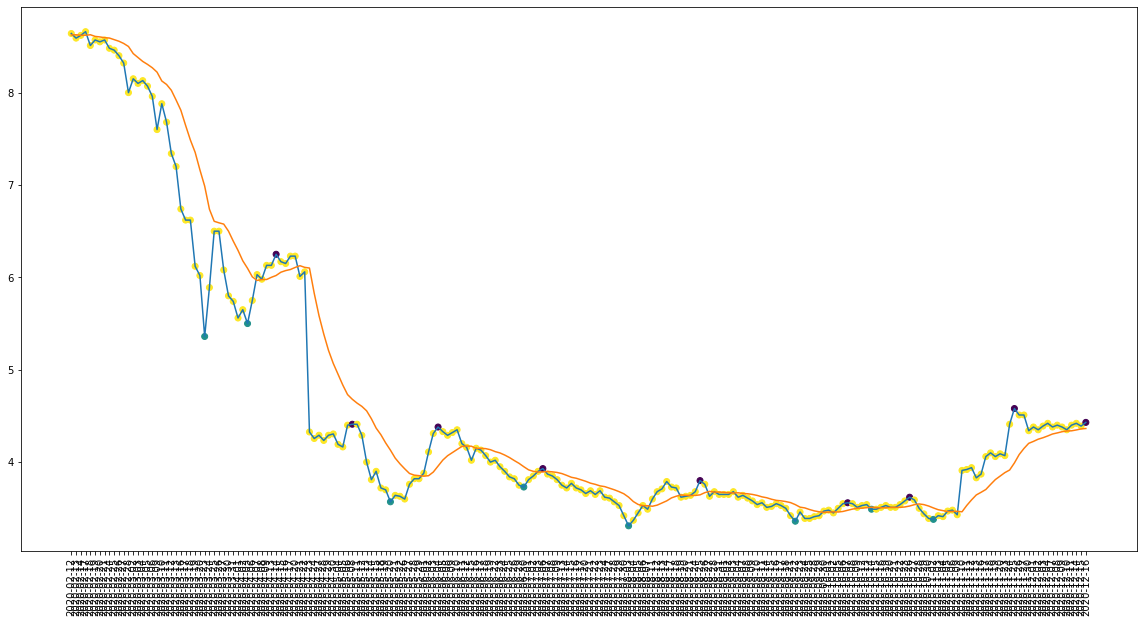

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [65]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 38
actual holds but predicted sell: 17
actual predicted holds: 143
Percentage buys correct: 37.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 72.22222222222223%
actual buys: 8
actual sells: 9
actual holds: 198


In [66]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 41.46341463414634%
Percentage sells correct: 65.0%
Percentage holds correct: 86.27450980392157%


In [67]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.319999694824219
Shares owned at the moment: 1157
Cash capital at the moment: $2.5197535114275524


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9233.065753511428


Share price: $8.130000114440918
Shares owned at the moment: 1132
Cash capital at the moment: $4.596933608054314


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $8584.138025948998


Share price: $6.739999771118164
Shares owned at the moment: 1270
Cash capital at the moment: $0.7988674282987631


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $7751.824622488018


Share price: $5.88999986

In [68]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


In [69]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   

        correct_holds    correct_low_buys correct_high_sells  \
0               76.5%  52.77777777777778%  58.8235294117647%   
1  72.22222222222223%  41.46341463414634%              65.0%   

    correct_mid_holds        Profit gained     buy_n_hold profit  
0   79.8780487804878%  -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%  3.6776627059422937%  -48.998182398364555%

### OCBC Bank

In [70]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


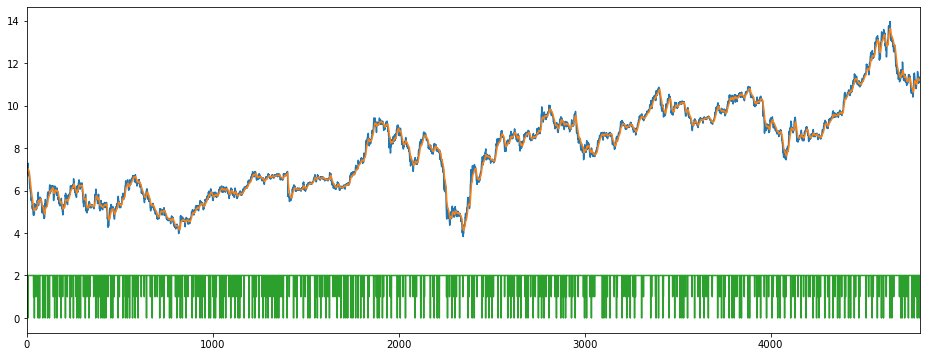

In [71]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [72]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [73]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [74]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [76]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4789, 64, 64, 1)

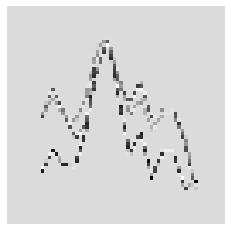

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}
Epoch 1/200
30/30 [==============================] - 8s 259ms/step - loss: 0.2436 - accuracy: 0.3078 - mse: 1.6904 - weighted_accuracy: 0.3398 - weighted_mse: 1.6643 - val_loss: 0.1956 - val_accuracy: 0.0553 - val_mse: 1.1629 - val_weighted_accuracy: 0.0553 - val_weighted_mse: 1.1629
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2042 - accuracy: 0.4738 - mse: 1.1586 - weighted_accuracy: 0.3449 - weighted_mse: 1.1815 - val_loss: 0.1990 - val_accuracy: 0.2463 - val_mse: 0.9286 - val_weighted_accuracy: 0.2463 - val_weighted_mse: 0.9286
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2045 - accuracy: 0.4062 - mse: 1.1653 - weighted_accuracy: 0.3414 - weighted_mse: 1.1694 - val_loss: 0.1979 - val_accuracy: 0.2568 - val_mse: 0.9094 - val_weighted_accuracy: 0.2568 - val_weighted_mse: 0.9094
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2039 

30/30 [==============================] - 0s 9ms/step - loss: 0.1956 - accuracy: 0.3399 - mse: 1.1701 - weighted_accuracy: 0.4214 - weighted_mse: 1.1663 - val_loss: 0.1911 - val_accuracy: 0.3184 - val_mse: 0.9686 - val_weighted_accuracy: 0.3184 - val_weighted_mse: 0.9686
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1936 - accuracy: 0.3111 - mse: 1.2032 - weighted_accuracy: 0.4025 - weighted_mse: 1.1878 - val_loss: 0.1962 - val_accuracy: 0.1148 - val_mse: 0.9441 - val_weighted_accuracy: 0.1148 - val_weighted_mse: 0.9441
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1946 - accuracy: 0.3049 - mse: 1.1807 - weighted_accuracy: 0.4068 - weighted_mse: 1.1582 - val_loss: 0.1915 - val_accuracy: 0.1722 - val_mse: 1.0391 - val_weighted_accuracy: 0.1722 - val_weighted_mse: 1.0391
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1940 - accuracy: 0.3333 - mse: 1.1919 - weighted_accuracy: 0.4170 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.2234 - mse: 1.3047 - weighted_accuracy: 0.5140 - weighted_mse: 1.2558 - val_loss: 0.1938 - val_accuracy: 0.1628 - val_mse: 1.0908 - val_weighted_accuracy: 0.1628 - val_weighted_mse: 1.0908
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1775 - accuracy: 0.2182 - mse: 1.3379 - weighted_accuracy: 0.4907 - weighted_mse: 1.2889 - val_loss: 0.1958 - val_accuracy: 0.1013 - val_mse: 1.1218 - val_weighted_accuracy: 0.1013 - val_weighted_mse: 1.1218
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1750 - accuracy: 0.2307 - mse: 1.3285 - weighted_accuracy: 0.4856 - weighted_mse: 1.2950 - val_loss: 0.1871 - val_accuracy: 0.2443 - val_mse: 1.1459 - val_weighted_accuracy: 0.2443 - val_weighted_mse: 1.1459
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1753 - accuracy: 0.2240 - mse: 1.3325 - weighted_accuracy: 0.5131 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1519 - accuracy: 0.2023 - mse: 1.6136 - weighted_accuracy: 0.6217 - weighted_mse: 1.5763 - val_loss: 0.1943 - val_accuracy: 0.1973 - val_mse: 1.4338 - val_weighted_accuracy: 0.1973 - val_weighted_mse: 1.4338
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1565 - accuracy: 0.2409 - mse: 1.5981 - weighted_accuracy: 0.5912 - weighted_mse: 1.5323 - val_loss: 0.2032 - val_accuracy: 0.1326 - val_mse: 1.3391 - val_weighted_accuracy: 0.1326 - val_weighted_mse: 1.3391
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1519 - accuracy: 0.2412 - mse: 1.5885 - weighted_accuracy: 0.6233 - weighted_mse: 1.5509 - val_loss: 0.1942 - val_accuracy: 0.2349 - val_mse: 1.5215 - val_weighted_accuracy: 0.2349 - val_weighted_mse: 1.5215
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1508 - accuracy: 0.2365 - mse: 1.6430 - weighted_accuracy: 0.6324 - weig

Epoch 115/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1292 - accuracy: 0.4176 - mse: 1.9754 - weighted_accuracy: 0.7118 - weighted_mse: 2.0878 - val_loss: 0.1816 - val_accuracy: 0.4081 - val_mse: 1.8173 - val_weighted_accuracy: 0.4081 - val_weighted_mse: 1.8173
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1288 - accuracy: 0.3931 - mse: 1.9822 - weighted_accuracy: 0.7173 - weighted_mse: 2.0690 - val_loss: 0.1828 - val_accuracy: 0.4071 - val_mse: 1.7873 - val_weighted_accuracy: 0.4071 - val_weighted_mse: 1.7873
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1292 - accuracy: 0.4022 - mse: 2.0272 - weighted_accuracy: 0.7150 - weighted_mse: 2.1007 - val_loss: 0.1790 - val_accuracy: 0.4353 - val_mse: 1.7925 - val_weighted_accuracy: 0.4353 - val_weighted_mse: 1.7925
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1290 - accuracy: 0.4137 - mse: 1.9733 - weighted_accuracy: 0.7307

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1149 - accuracy: 0.5628 - mse: 2.3339 - weighted_accuracy: 0.7901 - weighted_mse: 2.5302 - val_loss: 0.1735 - val_accuracy: 0.5063 - val_mse: 2.0282 - val_weighted_accuracy: 0.5063 - val_weighted_mse: 2.0282
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1159 - accuracy: 0.5565 - mse: 2.3099 - weighted_accuracy: 0.7705 - weighted_mse: 2.6462 - val_loss: 0.1614 - val_accuracy: 0.5793 - val_mse: 1.9674 - val_weighted_accuracy: 0.5793 - val_weighted_mse: 1.9674
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.5482 - mse: 2.3795 - weighted_accuracy: 0.7780 - weighted_mse: 2.7221 - val_loss: 0.1720 - val_accuracy: 0.5104 - val_mse: 2.0421 - val_weighted_accuracy: 0.5104 - val_weighted_mse: 2.0421
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.5521 - mse: 2.4664 - weighted_accuracy: 0.7883 

30/30 [==============================] - 0s 10ms/step - loss: 0.1001 - accuracy: 0.6578 - mse: 2.8495 - weighted_accuracy: 0.8152 - weighted_mse: 3.5007 - val_loss: 0.1480 - val_accuracy: 0.6597 - val_mse: 2.3683 - val_weighted_accuracy: 0.6597 - val_weighted_mse: 2.3683
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0984 - accuracy: 0.6432 - mse: 2.9212 - weighted_accuracy: 0.8092 - weighted_mse: 3.5914 - val_loss: 0.1396 - val_accuracy: 0.7067 - val_mse: 2.2909 - val_weighted_accuracy: 0.7067 - val_weighted_mse: 2.2909
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0997 - accuracy: 0.6505 - mse: 2.8077 - weighted_accuracy: 0.8122 - weighted_mse: 3.4485 - val_loss: 0.1446 - val_accuracy: 0.6806 - val_mse: 2.3797 - val_weighted_accuracy: 0.6806 - val_weighted_mse: 2.3797
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0945 - accuracy: 0.6536 - mse: 3.0126 - weighted_accuracy: 0.8223 - weighted_mse:

In [84]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13773275911808014
Test accuracy: 0.7108559608459473


In [85]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.03084438 -3.5321598  -0.7758785 ]
 [-3.0540066   0.016663   -0.75262654]
 [-1.0560324  -2.5205202   0.2026082 ]
 ...
 [-1.7968863  -1.1921618   0.05724641]
 [-0.75346506 -2.2713435  -0.06097244]
 [-1.8218837  -0.5975918  -0.27421236]]


Counter({0: 133, 1: 91, 2: 734})

In [86]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [87]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 36
actual holds but predicted buy: 83
actual holds but predicted sell: 124
actual predicted holds: 667
Percentage buys correct: 17.5%
Percentage sells correct: 15.909090909090908%
Percentage holds correct: 76.3157894736842%
actual buys: 40
actual sells: 44
actual holds: 874


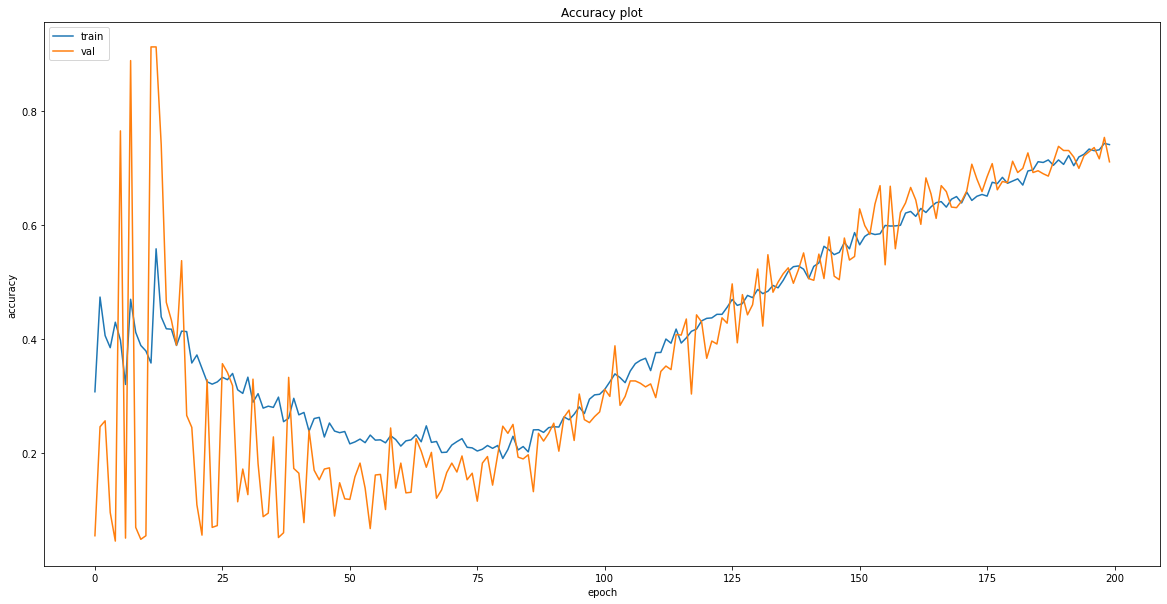

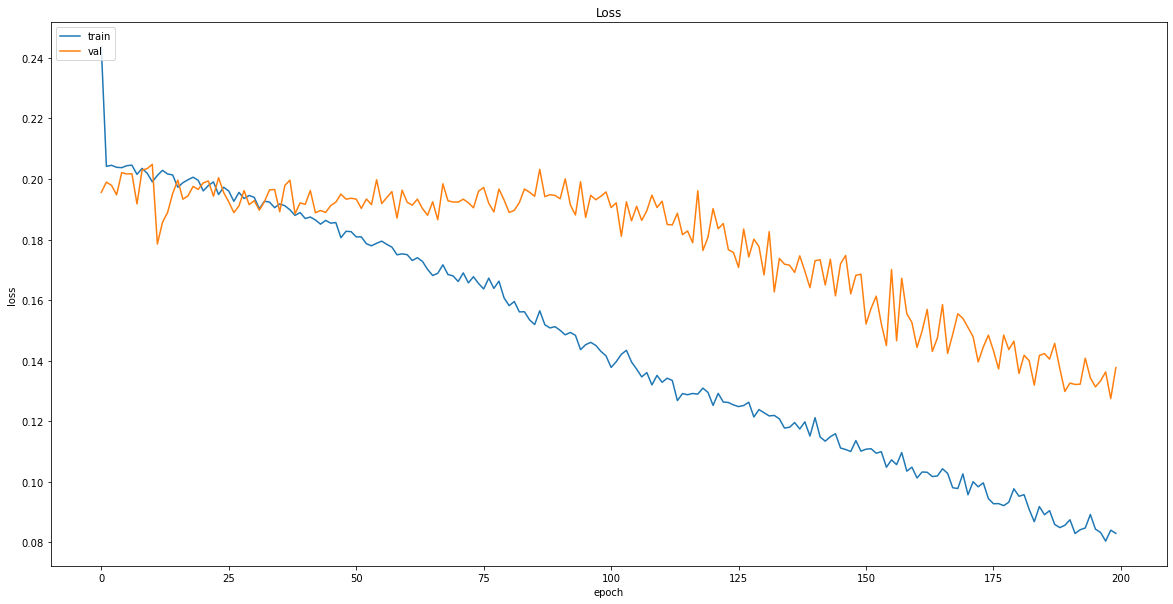

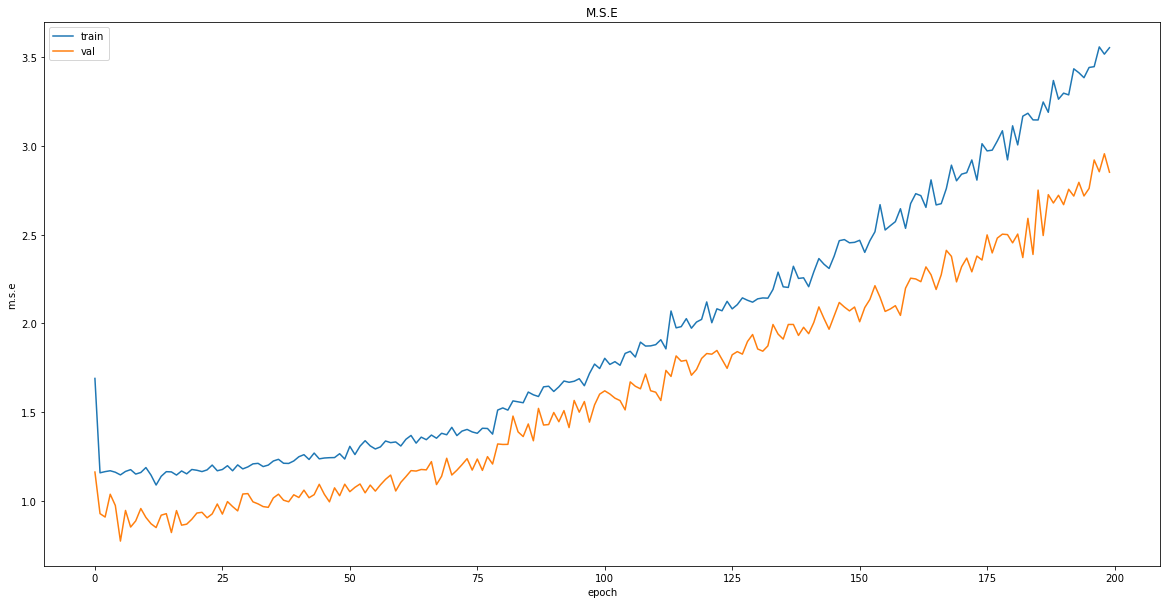

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

#### Non-Recession

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


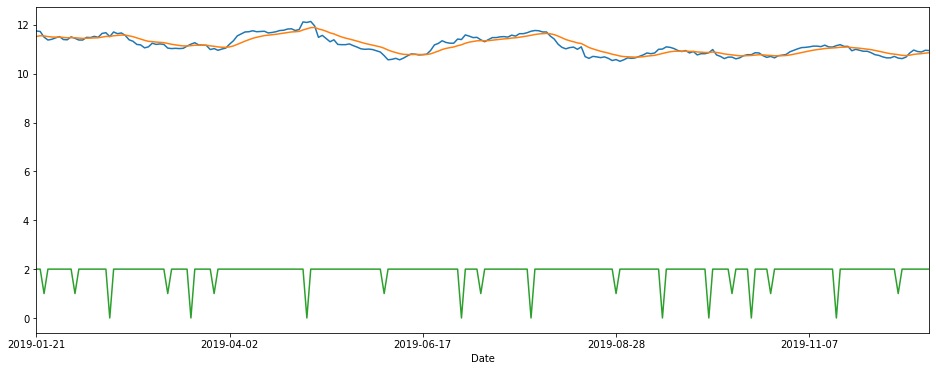

In [92]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

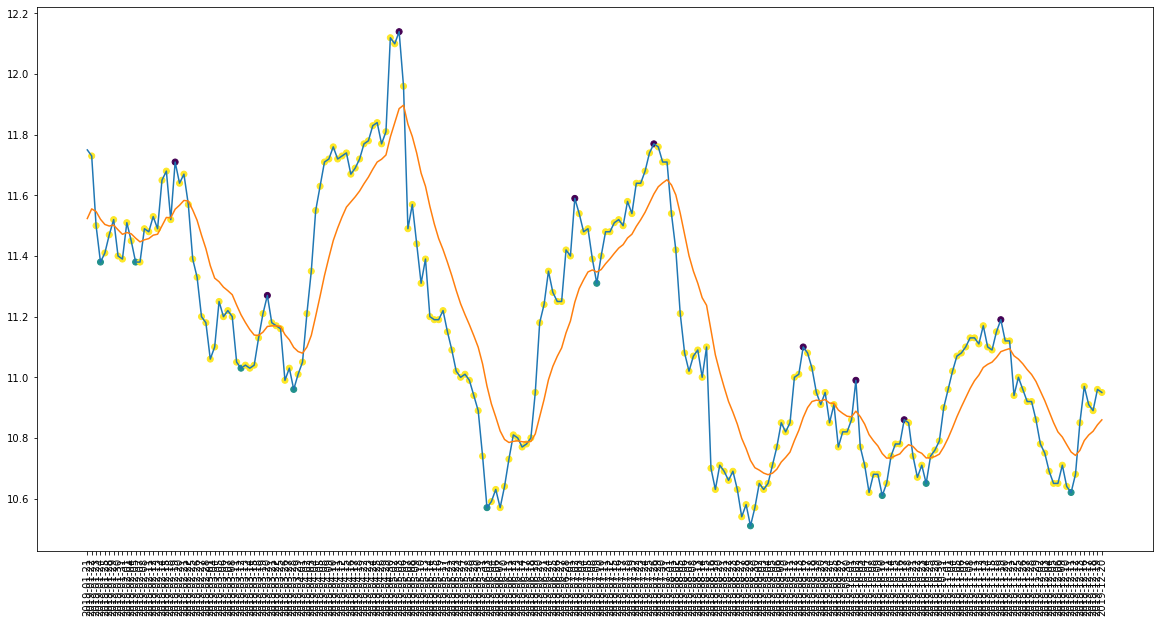

In [93]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [94]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [96]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [97]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [98]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.6835 - mean_squared_error: 2.9154 - weighted_accuracy: 0.6835 - weighted_mean_squared_error: 2.9154
Test loss: 0.13746796548366547
Test accuracy: 0.6834862232208252


In [99]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 162, 0: 36, 1: 20})

In [100]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [101]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [102]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            0       2  
2019-02-15            2       2

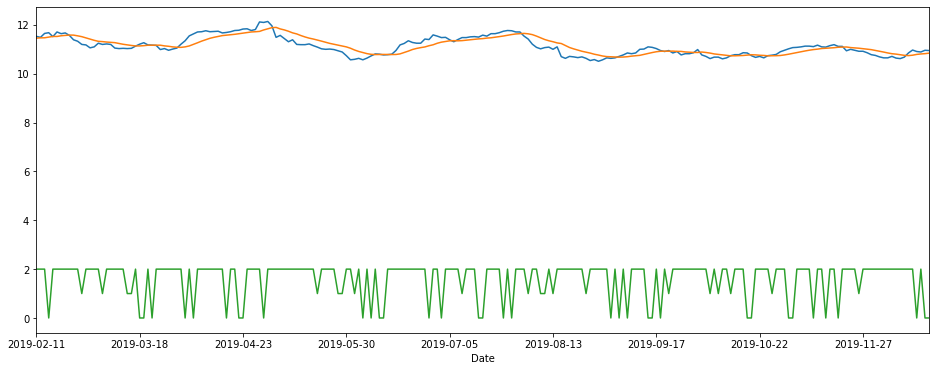

In [104]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

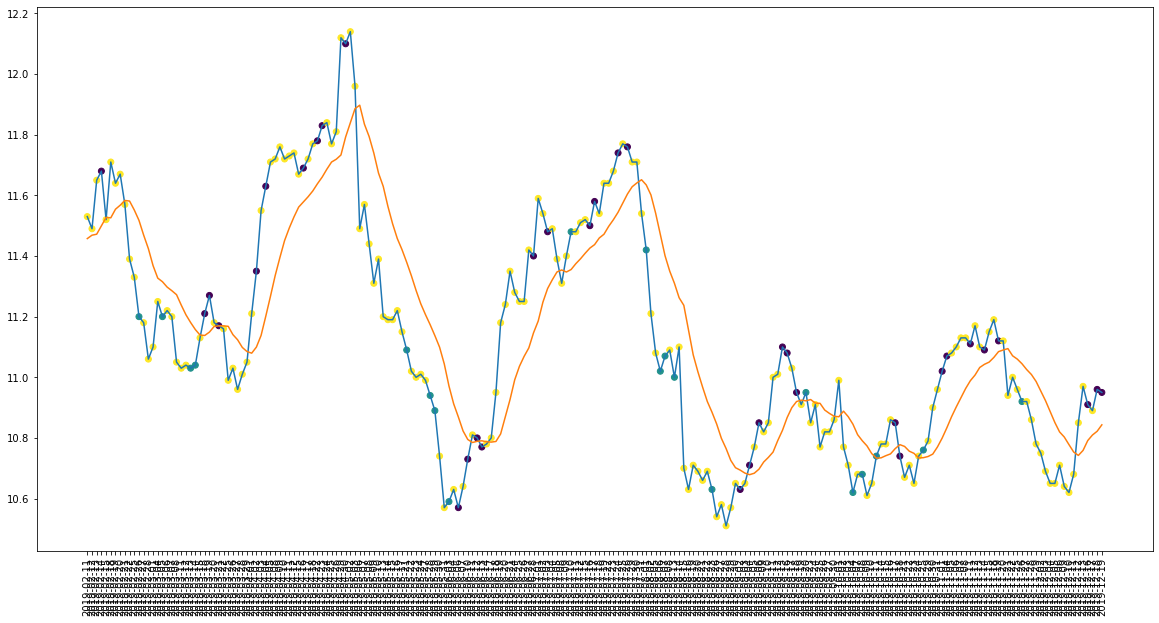

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

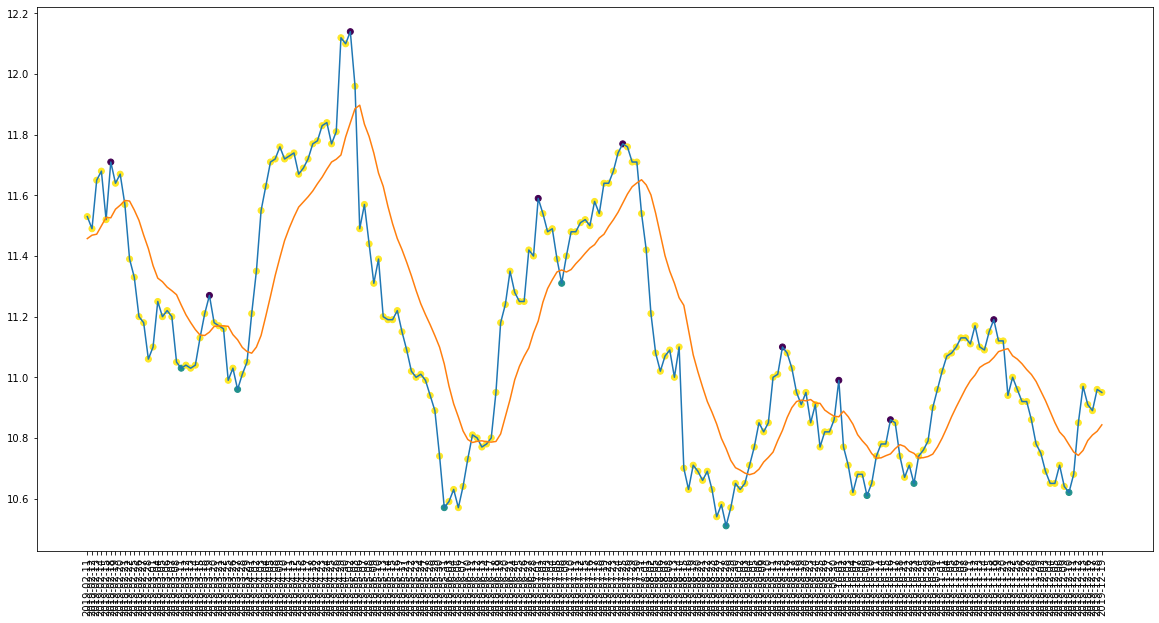

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [107]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 20
actual holds but predicted sell: 34
actual predicted holds: 147
Percentage buys correct: 0.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 73.13432835820896%
actual buys: 8
actual sells: 9
actual holds: 201


In [108]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 55.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 84.472049689441%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.199999809265137
Shares owned at the moment: 890
Cash capital at the moment: $4.58817022085168


Price increase from previously bought: 5.335328962939023%
Share price: $11.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10504.334177505969


Share price: $11.09000015258789
Shares owned at the moment: 944
Cash capital at the moment: $6.584393066881603


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10117.263137596605


Share price: $10.59000015258789
Shares owned at the moment: 952
Cash capital at the moment: $7.858371933458329


Price increase from previously bought: 7.3534979398849565%
Share price: $11.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10830.812809772966


Share price: $11.479999542236328
Shares owned at the moment: 940
Cash capital at the moment: $9.937441254136502


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned a

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   

        correct_holds    correct_low_buys  correct_high_sells  \
0               76.5%  52.77777777777778%   58.8235294117647%   
1  72.22222222222223%  41.46341463414634%               65.0%   
2  73.13432835820896%               55.0%  55.55555555555556%   

    correct_mid_holds        Profit gained     buy_n_hold profit  
0   79.8780487804878%  -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%  3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%   2.848248274831749%   -5.545324129943856%

#### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


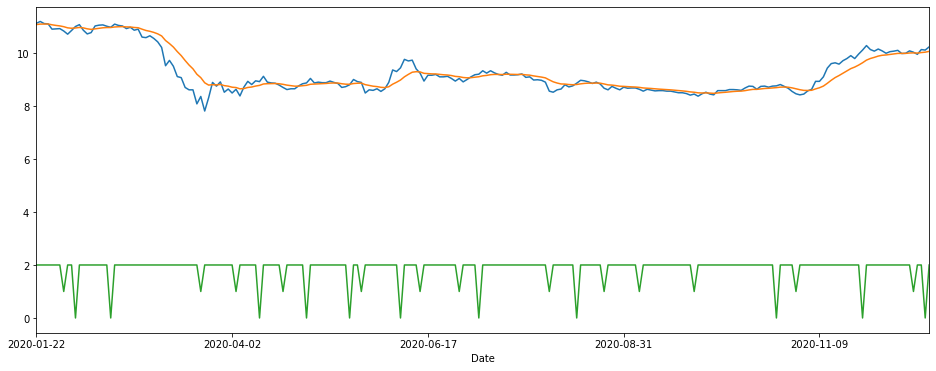

In [114]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

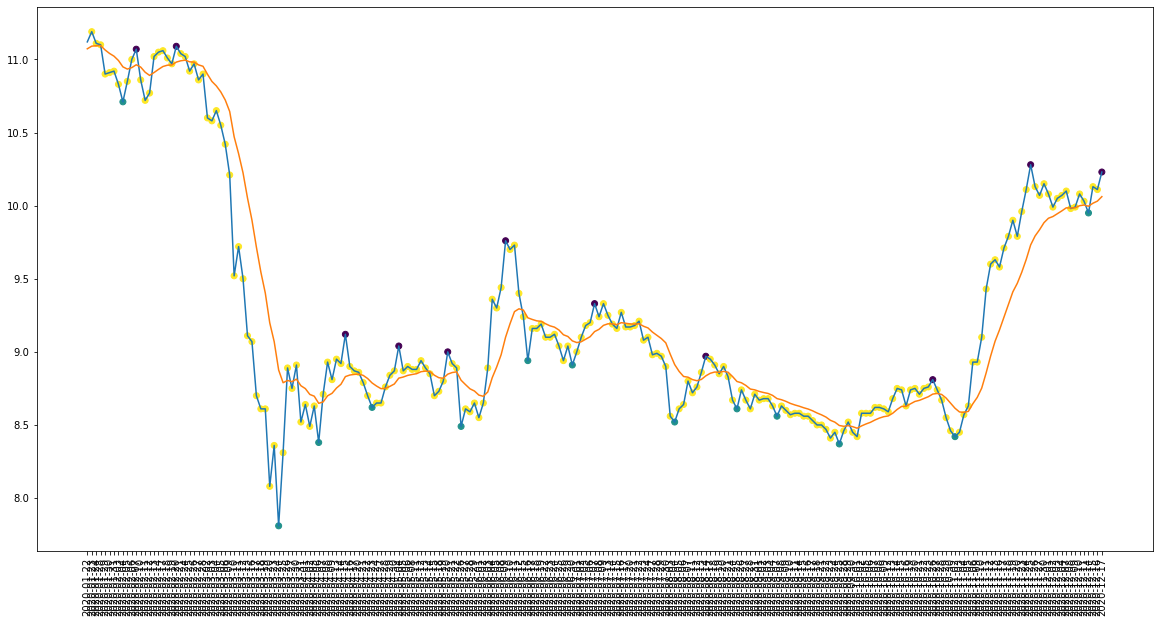

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.6837 - mean_squared_error: 2.9074 - weighted_accuracy: 0.6837 - weighted_mean_squared_error: 2.9074
Test loss: 0.13956467807292938
Test accuracy: 0.6837209463119507


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 36, 1: 19})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [123]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            0       2

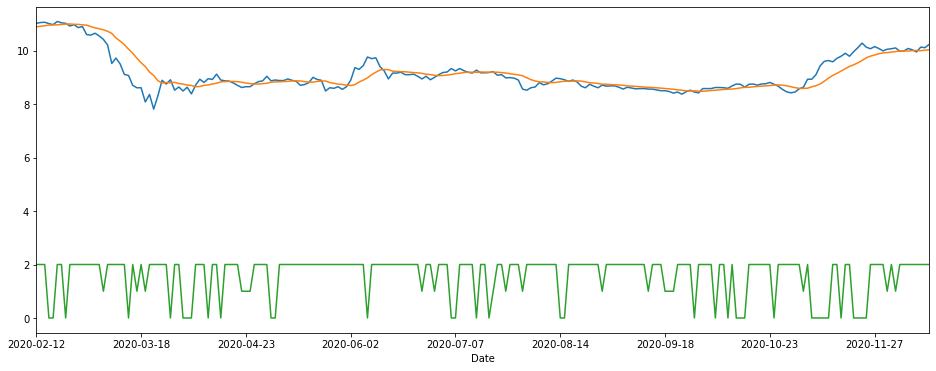

In [125]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

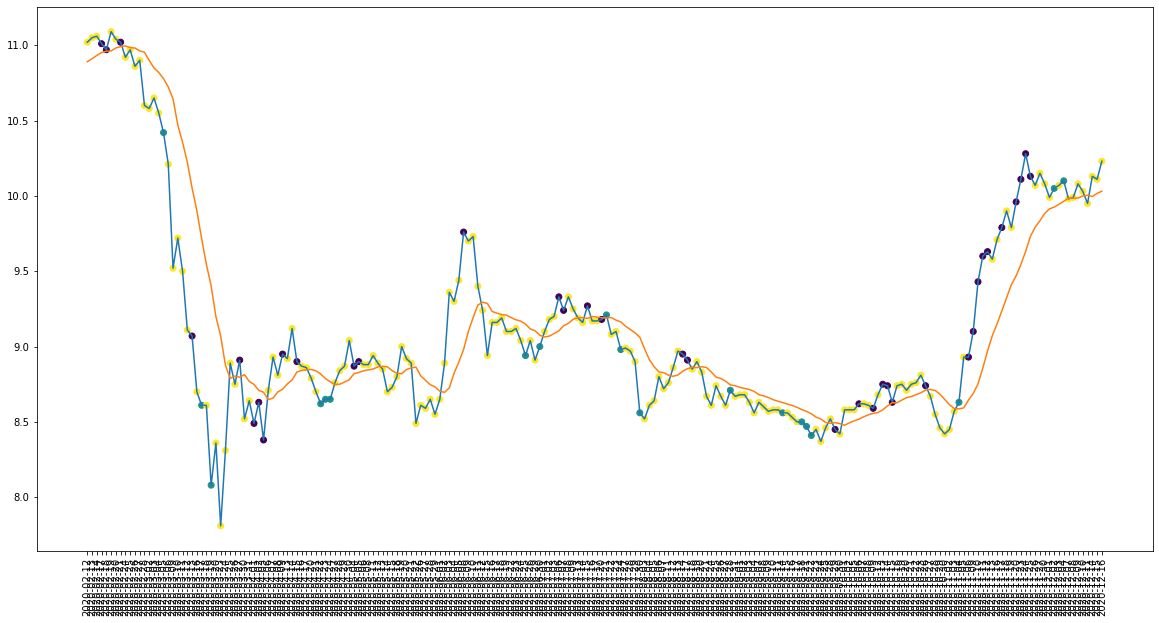

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

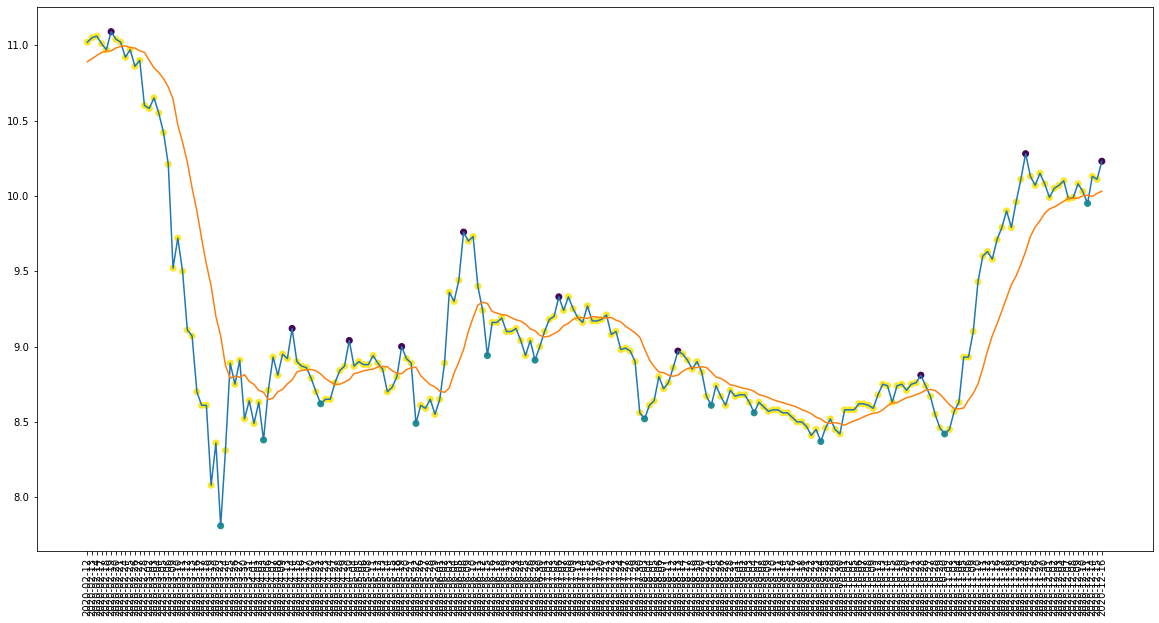

In [127]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [128]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 18
actual holds but predicted sell: 32
actual predicted holds: 143
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 30.0%
Percentage holds correct: 74.09326424870466%
actual buys: 12
actual sells: 10
actual holds: 193


In [129]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 63.1578947368421%
Percentage sells correct: 63.888888888888886%
Percentage holds correct: 86.16352201257861%


In [130]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.420000076293944
Shares owned at the moment: 957
Cash capital at the moment: $0.6370917859094334


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9086.223268661024


Share price: $8.609999656677246
Shares owned at the moment: 1052
Cash capital at the moment: $3.5949008297939145


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8480.379380789282


Share price: $8.079999923706055
Shares owned at the moment: 1046
Cash capital at the moment: $5.457340812206894


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8152.2518161242015


Share price: $8.619999885559082
Shares owned at the moment: 943
Cash capital at the moment: $1.2381093387612054


Price increase from previously bought: 12.91454715839604%
Share price: $9.760000228881836
Shares owned at the moment: 0
Cash capital at the mo

In [131]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [132]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   

        correct_holds    correct_low_buys   correct_high_sells  \
0               76.5%  52.77777777777778%    58.8235294117647%   
1  72.22222222222223%  41.46341463414634%                65.0%   
2  73.13432835820896%               55.0%   55.55555555555556%   
3  74.09326424870466%   63.1578947368421%  63.888888888888886%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%

## CNOOC Limited

In [133]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


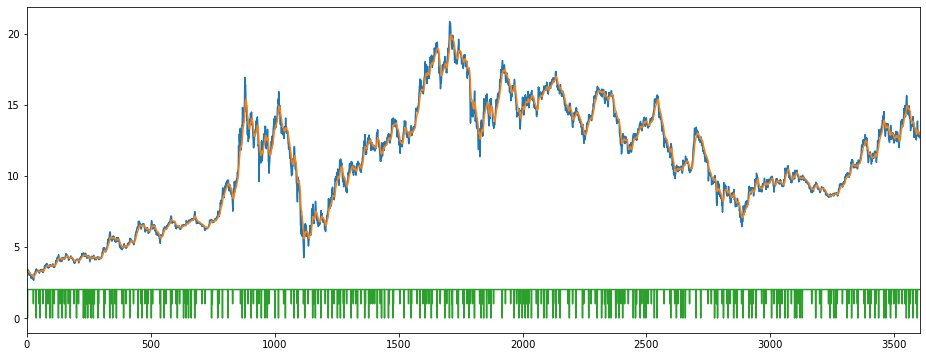

In [134]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [135]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [136]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [137]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [139]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3590, 64, 64, 1)

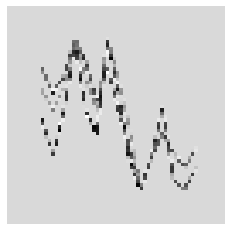

In [140]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [141]:
X = X/255

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}
Epoch 1/200
23/23 [==============================] - 2s 81ms/step - loss: 0.2670 - accuracy: 0.3684 - mse: 1.7893 - weighted_accuracy: 0.3381 - weighted_mse: 1.8222 - val_loss: 0.2260 - val_accuracy: 0.0460 - val_mse: 0.8479 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 0.8479
Epoch 2/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2090 - accuracy: 0.4464 - mse: 1.2303 - weighted_accuracy: 0.3572 - weighted_mse: 1.2398 - val_loss: 0.1916 - val_accuracy: 0.8997 - val_mse: 0.8253 - val_weighted_accuracy: 0.8997 - val_weighted_mse: 0.8253
Epoch 3/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2052 - accuracy: 0.3952 - mse: 1.1229 - weighted_accuracy: 0.3283 - weighted_mse: 1.1586 - val_loss: 0.1964 - val_accuracy: 0.0460 - val_mse: 0.9782 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 0.9782
Epoch 4/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2050 -

23/23 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.2859 - mse: 1.2048 - weighted_accuracy: 0.3975 - weighted_mse: 1.1723 - val_loss: 0.2021 - val_accuracy: 0.0710 - val_mse: 0.9774 - val_weighted_accuracy: 0.0710 - val_weighted_mse: 0.9774
Epoch 29/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1958 - accuracy: 0.2925 - mse: 1.2150 - weighted_accuracy: 0.4216 - weighted_mse: 1.2029 - val_loss: 0.1988 - val_accuracy: 0.0752 - val_mse: 0.9666 - val_weighted_accuracy: 0.0752 - val_weighted_mse: 0.9666
Epoch 30/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1956 - accuracy: 0.2765 - mse: 1.1698 - weighted_accuracy: 0.3770 - weighted_mse: 1.1584 - val_loss: 0.1980 - val_accuracy: 0.0766 - val_mse: 1.0334 - val_weighted_accuracy: 0.0766 - val_weighted_mse: 1.0334
Epoch 31/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1895 - accuracy: 0.3196 - mse: 1.2203 - weighted_accuracy: 0.4555 - weighted_mse: 1.1

Epoch 57/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1824 - accuracy: 0.1539 - mse: 1.2719 - weighted_accuracy: 0.5041 - weighted_mse: 1.2364 - val_loss: 0.2024 - val_accuracy: 0.0738 - val_mse: 1.0132 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0132
Epoch 58/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.1588 - mse: 1.3001 - weighted_accuracy: 0.5108 - weighted_mse: 1.2696 - val_loss: 0.1983 - val_accuracy: 0.0738 - val_mse: 1.0742 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0742
Epoch 59/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.1654 - mse: 1.3242 - weighted_accuracy: 0.5177 - weighted_mse: 1.2852 - val_loss: 0.2003 - val_accuracy: 0.0738 - val_mse: 1.1061 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.1061
Epoch 60/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1772 - accuracy: 0.1431 - mse: 1.3481 - weighted_accuracy: 0.5555 - weig

Epoch 86/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1683 - accuracy: 0.1741 - mse: 1.4038 - weighted_accuracy: 0.5426 - weighted_mse: 1.3692 - val_loss: 0.1950 - val_accuracy: 0.0989 - val_mse: 1.1855 - val_weighted_accuracy: 0.0989 - val_weighted_mse: 1.1855
Epoch 87/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1670 - accuracy: 0.1727 - mse: 1.3848 - weighted_accuracy: 0.5322 - weighted_mse: 1.3727 - val_loss: 0.1965 - val_accuracy: 0.1031 - val_mse: 1.1808 - val_weighted_accuracy: 0.1031 - val_weighted_mse: 1.1808
Epoch 88/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1660 - accuracy: 0.1877 - mse: 1.3972 - weighted_accuracy: 0.5620 - weighted_mse: 1.3565 - val_loss: 0.1984 - val_accuracy: 0.1003 - val_mse: 1.2392 - val_weighted_accuracy: 0.1003 - val_weighted_mse: 1.2392
Epoch 89/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1684 - accuracy: 0.1671 - mse: 1.4398 - weighted_accuracy: 0.5355 - weig

Epoch 115/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1511 - accuracy: 0.2225 - mse: 1.5147 - weighted_accuracy: 0.6015 - weighted_mse: 1.5345 - val_loss: 0.1970 - val_accuracy: 0.1504 - val_mse: 1.3921 - val_weighted_accuracy: 0.1504 - val_weighted_mse: 1.3921
Epoch 116/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1540 - accuracy: 0.2218 - mse: 1.5122 - weighted_accuracy: 0.5819 - weighted_mse: 1.5311 - val_loss: 0.1975 - val_accuracy: 0.1685 - val_mse: 1.2934 - val_weighted_accuracy: 0.1685 - val_weighted_mse: 1.2934
Epoch 117/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1504 - accuracy: 0.2228 - mse: 1.5307 - weighted_accuracy: 0.6280 - weighted_mse: 1.5702 - val_loss: 0.1957 - val_accuracy: 0.1504 - val_mse: 1.3656 - val_weighted_accuracy: 0.1504 - val_weighted_mse: 1.3656
Epoch 118/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1543 - accuracy: 0.2375 - mse: 1.5067 - weighted_accuracy: 0.5995 - 

Epoch 144/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1421 - accuracy: 0.3249 - mse: 1.6597 - weighted_accuracy: 0.6148 - weighted_mse: 1.7583 - val_loss: 0.1875 - val_accuracy: 0.2604 - val_mse: 1.4338 - val_weighted_accuracy: 0.2604 - val_weighted_mse: 1.4338
Epoch 145/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.3249 - mse: 1.6718 - weighted_accuracy: 0.6170 - weighted_mse: 1.7676 - val_loss: 0.1894 - val_accuracy: 0.2646 - val_mse: 1.4920 - val_weighted_accuracy: 0.2646 - val_weighted_mse: 1.4920
Epoch 146/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1422 - accuracy: 0.3377 - mse: 1.6288 - weighted_accuracy: 0.6290 - weighted_mse: 1.7435 - val_loss: 0.1830 - val_accuracy: 0.3106 - val_mse: 1.5034 - val_weighted_accuracy: 0.3106 - val_weighted_mse: 1.5034
Epoch 147/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1410 - accuracy: 0.3621 - mse: 1.6436 - weighted_accuracy: 0.6355 - 

Epoch 173/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1294 - accuracy: 0.4614 - mse: 1.8173 - weighted_accuracy: 0.6814 - weighted_mse: 2.0778 - val_loss: 0.1698 - val_accuracy: 0.4805 - val_mse: 1.6439 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 1.6439
Epoch 174/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1347 - accuracy: 0.4676 - mse: 1.7301 - weighted_accuracy: 0.6257 - weighted_mse: 1.9159 - val_loss: 0.1815 - val_accuracy: 0.4067 - val_mse: 1.6200 - val_weighted_accuracy: 0.4067 - val_weighted_mse: 1.6200
Epoch 175/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.4603 - mse: 1.8064 - weighted_accuracy: 0.6692 - weighted_mse: 2.0794 - val_loss: 0.1779 - val_accuracy: 0.4304 - val_mse: 1.6617 - val_weighted_accuracy: 0.4304 - val_weighted_mse: 1.6617
Epoch 176/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1263 - accuracy: 0.4697 - mse: 1.7765 - weighted_accuracy: 0.6989 - 

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.16196557879447937
Test accuracy: 0.5696378946304321


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1984092  -0.80529565 -0.33728993]
 [-1.0668159  -0.9520545  -0.32267705]
 [-2.282981   -0.05935369 -0.72955674]
 ...
 [-2.0797415  -0.25160667 -0.60165566]
 [-0.7990401  -1.158371   -0.44542894]
 [-1.487757   -0.67009664 -0.35891688]]


Counter({2: 424, 1: 129, 0: 165})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 13
actual buys but predicted sell: 1
actual buys but predicted hold: 18
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 21
actual holds but predicted buy: 115
actual holds but predicted sell: 153
actual predicted holds: 385
Percentage buys correct: 40.625%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 58.95865237366003%
actual buys: 32
actual sells: 33
actual holds: 653


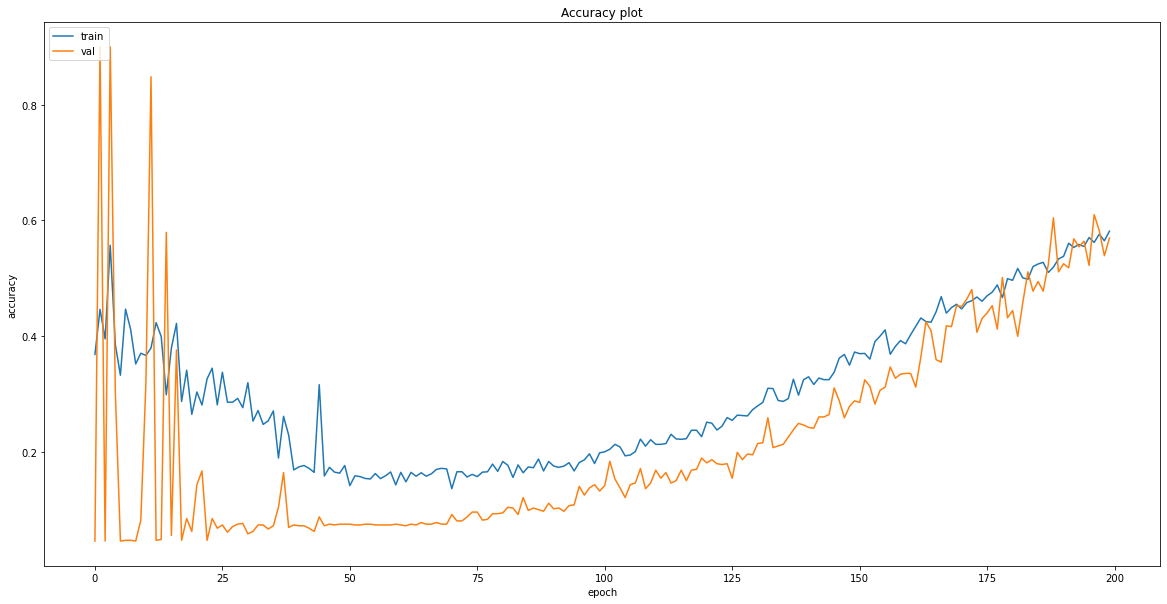

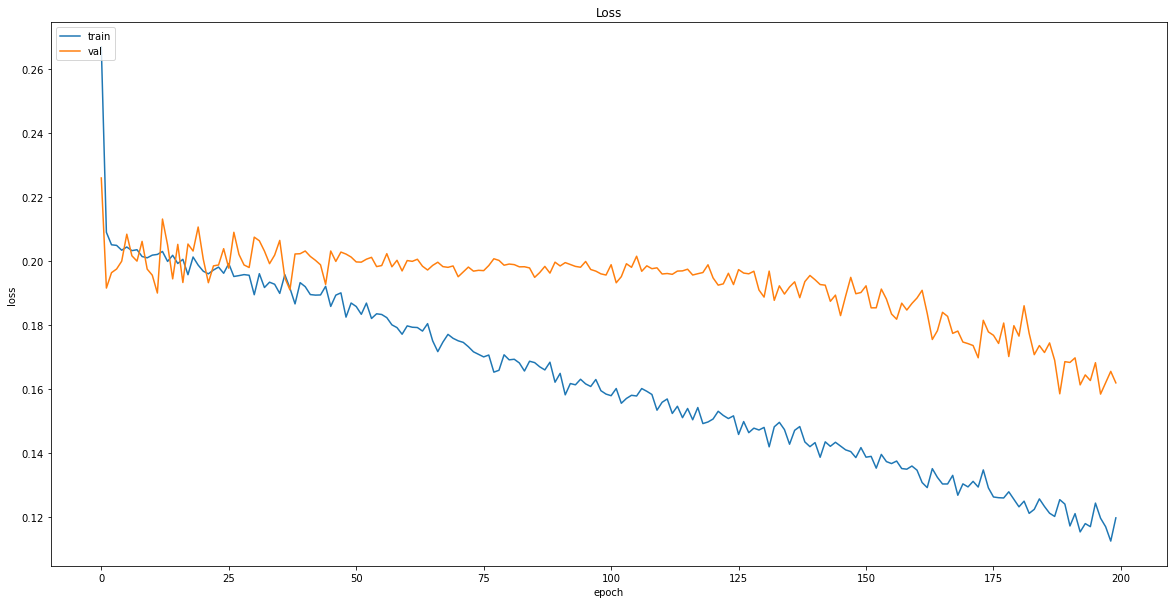

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

#### Non-Recession

In [153]:
logger = []

In [154]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


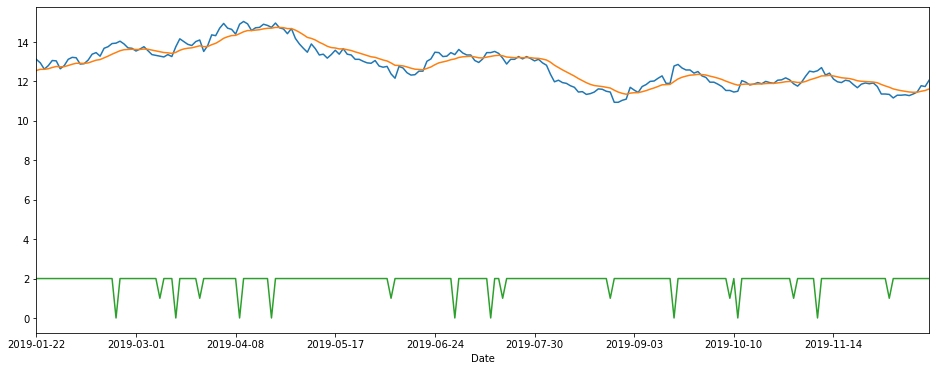

In [155]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [156]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [158]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [159]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [160]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1586 - accuracy: 0.6019 - mean_squared_error: 1.6975 - weighted_accuracy: 0.6019 - weighted_mean_squared_error: 1.6975
Test loss: 0.15861688554286957
Test accuracy: 0.6018957495689392


In [161]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 128, 0: 41, 1: 42})

In [162]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [163]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [164]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            2       2  
2019-02-15            2       2  
2019-02-18            0       2  
2019-02-19            0       2  
2019-02-20            2       2

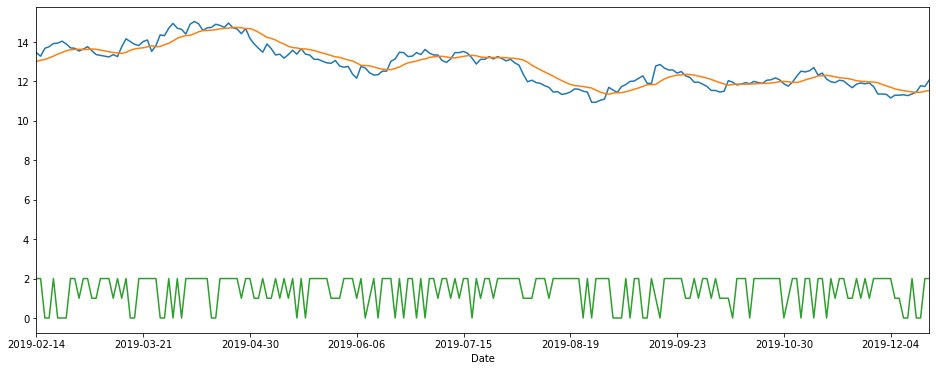

In [165]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

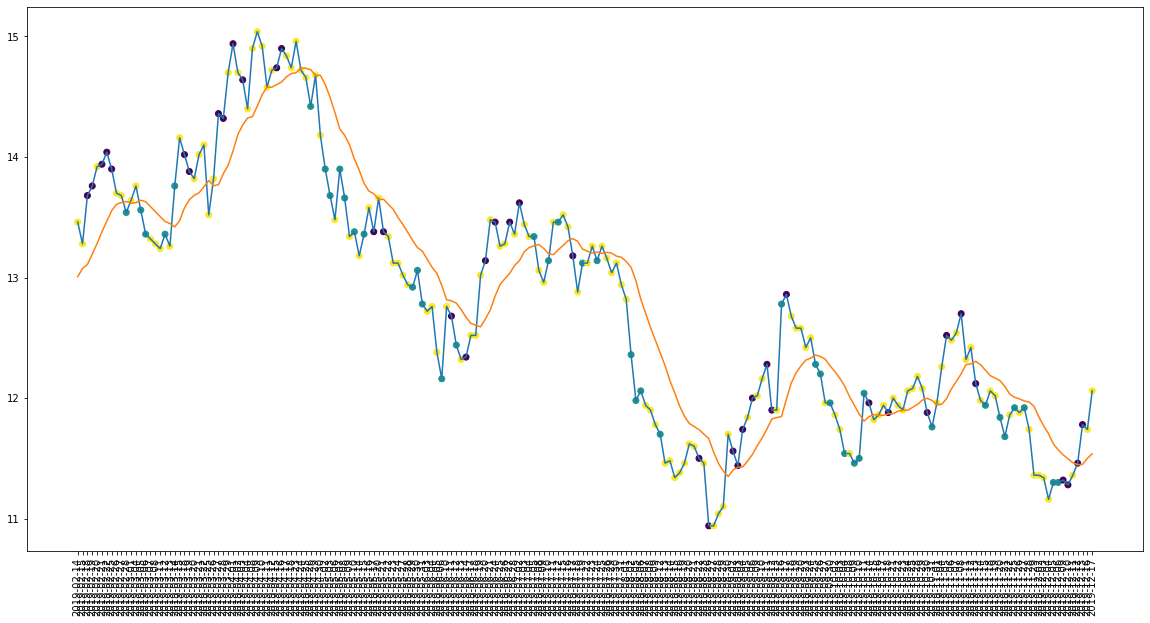

In [166]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

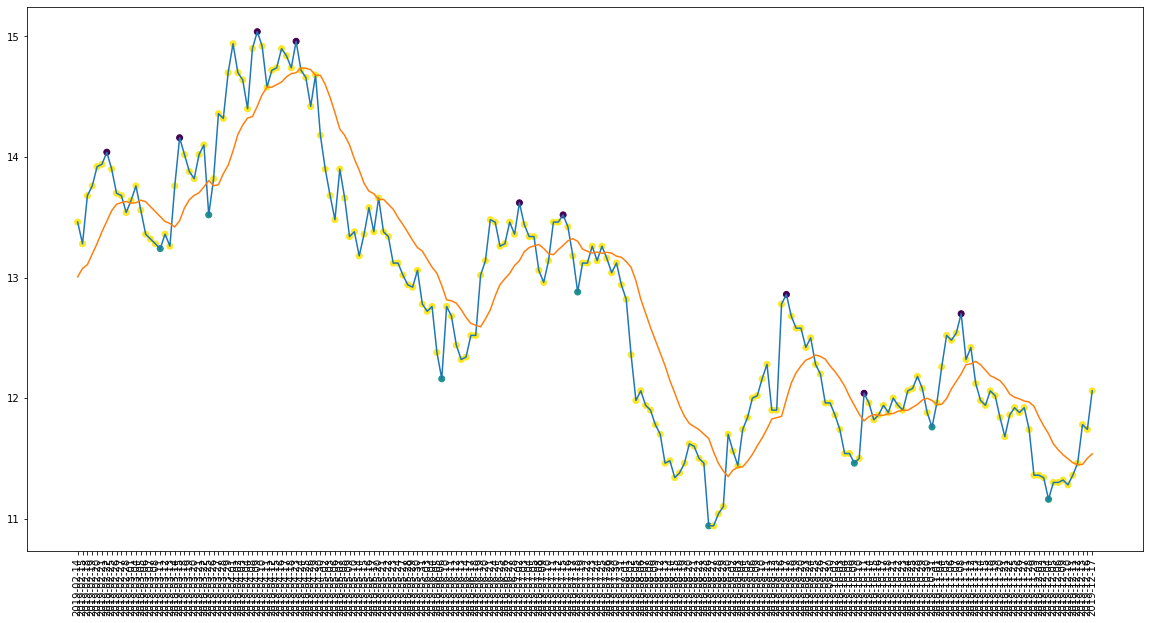

In [167]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [168]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 38
actual holds but predicted sell: 36
actual predicted holds: 120
Percentage buys correct: 37.5%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 61.855670103092784%
actual buys: 8
actual sells: 9
actual holds: 194


In [169]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 52.38095238095238%
Percentage sells correct: 53.65853658536585%
Percentage holds correct: 81.10236220472441%


In [170]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.539999961853027
Shares owned at the moment: 736
Cash capital at the moment: $7.155068153380853


Price increase from previously bought: 5.765273246978819%
Share price: $14.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $10547.050176162717


Share price: $14.420000076293945
Shares owned at the moment: 729
Cash capital at the moment: $5.961625391479174


Stop Loss Activated!

Share price: $13.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10111.1953230648


Share price: $13.899999618530273
Shares owned at the moment: 725
Cash capital at the moment: $5.982475390906984


Stop Loss Activated!

Share price: $13.479999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9752.10639442491


Share price: $13.899999618530273
Shares owned at the moment: 699
Cash capital at the moment: $9.287386805530332


Stop Loss Activated!

Share price: $13.34000015258789
Shares owned at the moment: 0
Cash capital at the mom

In [171]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [172]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%

### Recession

In [173]:
logger = []

In [174]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [175]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [177]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [178]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [179]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1601 - accuracy: 0.6009 - mean_squared_error: 1.7064 - weighted_accuracy: 0.6009 - weighted_mean_squared_error: 1.7064
Test loss: 0.16008903086185455
Test accuracy: 0.6009389758110046


In [180]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 130, 1: 40, 0: 43})

In [181]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [182]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [183]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2  
2020-02-19            2       2

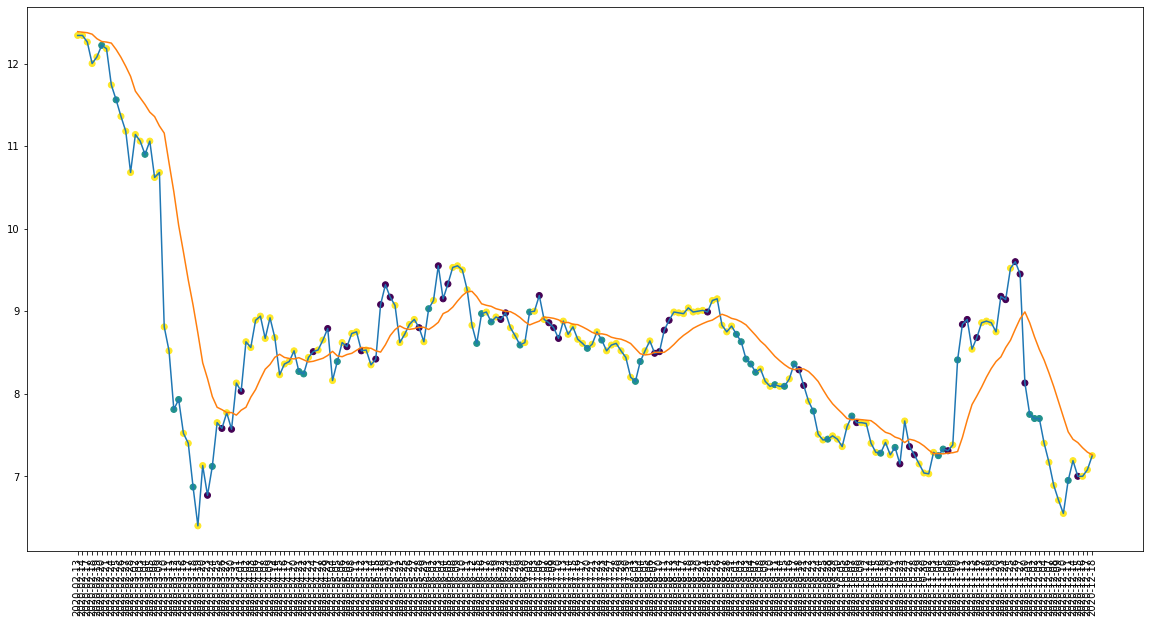

In [184]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

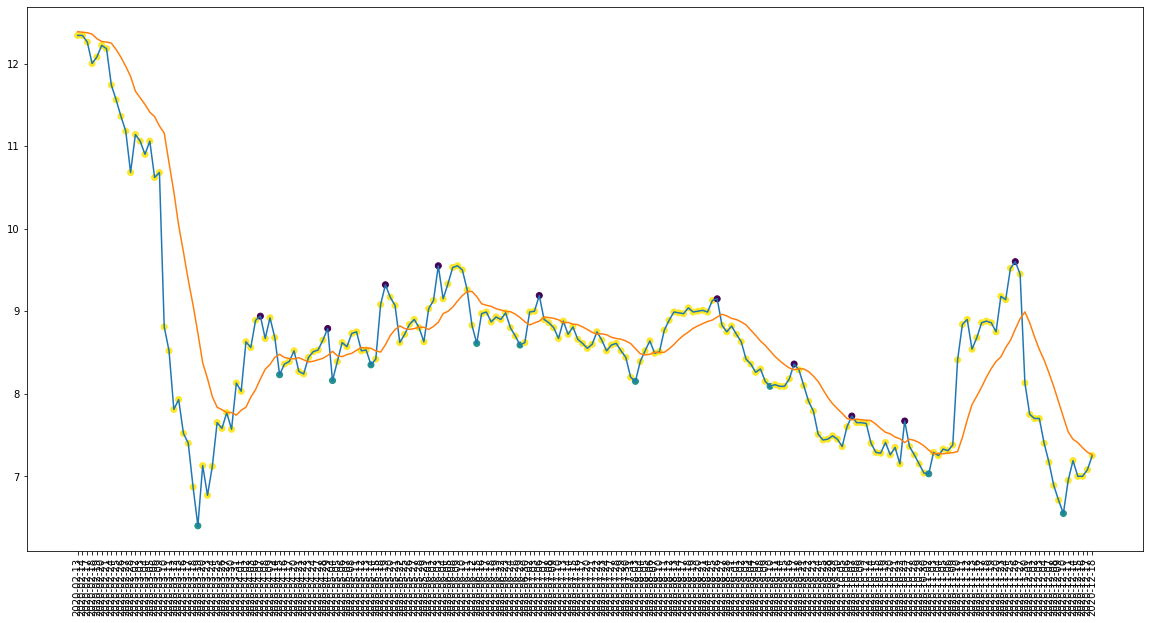

In [185]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [186]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 35
actual holds but predicted sell: 38
actual predicted holds: 120
Percentage buys correct: 30.0%
Percentage sells correct: 50.0%
Percentage holds correct: 62.17616580310881%
actual buys: 10
actual sells: 10
actual holds: 193


In [187]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 50.0%
Percentage sells correct: 39.53488372093023%
Percentage holds correct: 82.17054263565892%


In [188]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.220000267028807
Shares owned at the moment: 816
Cash capital at the moment: $1.058101505281229


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9554.553355251313


Share price: $11.5600004196167
Shares owned at the moment: 824
Cash capital at the moment: $2.918048536301285


Stop Loss Activated!

Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9189.904419309614


Share price: $10.899999618530273
Shares owned at the moment: 840
Cash capital at the moment: $8.72574062537933


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7388.774992134092


Share price: $7.809999942779541
Shares owned at the moment: 943
Cash capital at the moment: $3.6917637413716875


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7075.550505804536


Share price: $6.

In [189]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [190]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   
5       0.600939                30.0%                50.0%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   
5   62.17616580310881%               50.0%   39.53488372093023%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%  
5  82.17054263565892%  -13.142344483392279%   -41.56249103630067%

## JP Morgan

In [191]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


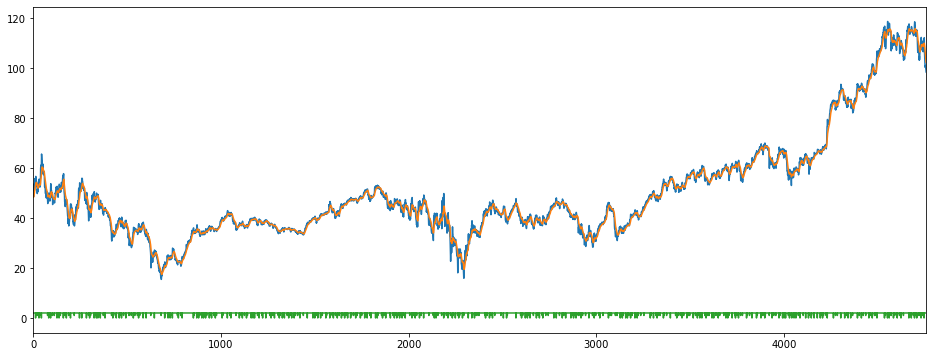

In [192]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [193]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [194]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [195]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [197]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

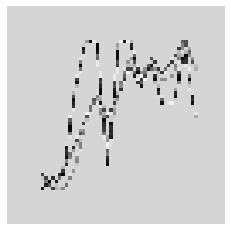

In [198]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [199]:
X = X/255

In [200]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [201]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [202]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [204]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 2s 69ms/step - loss: 0.2489 - accuracy: 0.4376 - mse: 1.6430 - weighted_accuracy: 0.3304 - weighted_mse: 1.7659 - val_loss: 0.2055 - val_accuracy: 0.0516 - val_mse: 0.9367 - val_weighted_accuracy: 0.0516 - val_weighted_mse: 0.9367
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2053 - accuracy: 0.2476 - mse: 1.2114 - weighted_accuracy: 0.3190 - weighted_mse: 1.1866 - val_loss: 0.2086 - val_accuracy: 0.0432 - val_mse: 0.9825 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.9825
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2036 - accuracy: 0.3087 - mse: 1.1796 - weighted_accuracy: 0.3305 - weighted_mse: 1.1770 - val_loss: 0.2076 - val_accuracy: 0.0843 - val_mse: 0.8362 - val_weighted_accuracy: 0.0843 - val_weighted_mse: 0.8362
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.202

30/30 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.3519 - mse: 1.1660 - weighted_accuracy: 0.3744 - weighted_mse: 1.1533 - val_loss: 0.1956 - val_accuracy: 0.1612 - val_mse: 0.9263 - val_weighted_accuracy: 0.1612 - val_weighted_mse: 0.9263
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.3219 - mse: 1.1796 - weighted_accuracy: 0.3953 - weighted_mse: 1.1787 - val_loss: 0.1914 - val_accuracy: 0.3446 - val_mse: 0.9407 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 0.9407
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.3472 - mse: 1.1718 - weighted_accuracy: 0.4010 - weighted_mse: 1.1805 - val_loss: 0.1910 - val_accuracy: 0.4162 - val_mse: 0.9292 - val_weighted_accuracy: 0.4162 - val_weighted_mse: 0.9292
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.3122 - mse: 1.1840 - weighted_accuracy: 0.3957 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1805 - accuracy: 0.2297 - mse: 1.3095 - weighted_accuracy: 0.4764 - weighted_mse: 1.2542 - val_loss: 0.1952 - val_accuracy: 0.1391 - val_mse: 1.0186 - val_weighted_accuracy: 0.1391 - val_weighted_mse: 1.0186
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.2110 - mse: 1.2767 - weighted_accuracy: 0.5034 - weighted_mse: 1.2635 - val_loss: 0.1843 - val_accuracy: 0.2403 - val_mse: 1.1256 - val_weighted_accuracy: 0.2403 - val_weighted_mse: 1.1256
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1787 - accuracy: 0.2292 - mse: 1.2836 - weighted_accuracy: 0.5008 - weighted_mse: 1.2484 - val_loss: 0.1883 - val_accuracy: 0.2150 - val_mse: 1.0815 - val_weighted_accuracy: 0.2150 - val_weighted_mse: 1.0815
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1791 - accuracy: 0.2160 - mse: 1.2692 - weighted_accuracy: 0.4913 - we

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.2081 - mse: 1.5177 - weighted_accuracy: 0.6116 - weighted_mse: 1.5293 - val_loss: 0.1925 - val_accuracy: 0.2160 - val_mse: 1.2407 - val_weighted_accuracy: 0.2160 - val_weighted_mse: 1.2407
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1563 - accuracy: 0.2152 - mse: 1.5203 - weighted_accuracy: 0.6301 - weighted_mse: 1.4676 - val_loss: 0.1914 - val_accuracy: 0.2413 - val_mse: 1.3193 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.3193
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1556 - accuracy: 0.2152 - mse: 1.5005 - weighted_accuracy: 0.6148 - weighted_mse: 1.4487 - val_loss: 0.1901 - val_accuracy: 0.2792 - val_mse: 1.3654 - val_weighted_accuracy: 0.2792 - val_weighted_mse: 1.3654
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1525 - accuracy: 0.2221 - mse: 1.5155 - weighted_accuracy: 0.6341 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1342 - accuracy: 0.3625 - mse: 1.7540 - weighted_accuracy: 0.6869 - weighted_mse: 1.8544 - val_loss: 0.1747 - val_accuracy: 0.4257 - val_mse: 1.5426 - val_weighted_accuracy: 0.4257 - val_weighted_mse: 1.5426
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.3822 - mse: 1.7395 - weighted_accuracy: 0.7037 - weighted_mse: 1.8084 - val_loss: 0.1842 - val_accuracy: 0.3793 - val_mse: 1.5680 - val_weighted_accuracy: 0.3793 - val_weighted_mse: 1.5680
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1314 - accuracy: 0.3469 - mse: 1.7341 - weighted_accuracy: 0.7079 - weighted_mse: 1.8479 - val_loss: 0.1894 - val_accuracy: 0.3625 - val_mse: 1.5932 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.5932
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1300 - accuracy: 0.3617 - mse: 1.7803 - weighted_accuracy: 0.7021 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1139 - accuracy: 0.5295 - mse: 2.0746 - weighted_accuracy: 0.7555 - weighted_mse: 2.4477 - val_loss: 0.1586 - val_accuracy: 0.5827 - val_mse: 1.7798 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 1.7798
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1144 - accuracy: 0.5329 - mse: 2.0536 - weighted_accuracy: 0.7664 - weighted_mse: 2.3853 - val_loss: 0.1673 - val_accuracy: 0.5342 - val_mse: 1.7147 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 1.7147
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1106 - accuracy: 0.5421 - mse: 2.0912 - weighted_accuracy: 0.7926 - weighted_mse: 2.4767 - val_loss: 0.1507 - val_accuracy: 0.6175 - val_mse: 1.7589 - val_weighted_accuracy: 0.6175 - val_weighted_mse: 1.7589
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1143 - accuracy: 0.5711 - mse: 2.1148 - weighted_accuracy: 0.7635 - 

30/30 [==============================] - 0s 9ms/step - loss: 0.0941 - accuracy: 0.6712 - mse: 2.4224 - weighted_accuracy: 0.8208 - weighted_mse: 3.1762 - val_loss: 0.1426 - val_accuracy: 0.6670 - val_mse: 1.9364 - val_weighted_accuracy: 0.6670 - val_weighted_mse: 1.9364
Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0888 - accuracy: 0.6839 - mse: 2.5890 - weighted_accuracy: 0.8310 - weighted_mse: 3.5149 - val_loss: 0.1422 - val_accuracy: 0.6733 - val_mse: 2.0526 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 2.0526
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0940 - accuracy: 0.6807 - mse: 2.4677 - weighted_accuracy: 0.8220 - weighted_mse: 3.3221 - val_loss: 0.1540 - val_accuracy: 0.6344 - val_mse: 2.1775 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 2.1775
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0961 - accuracy: 0.6649 - mse: 2.5484 - weighted_accuracy: 0.8035 - weighted_mse

In [205]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.12086866050958633
Test accuracy: 0.779768168926239


In [206]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.7035767  -1.0995781   0.09224749]
 [-1.1271907  -2.7369938   0.21568707]
 [-0.07122692 -3.240088   -0.59794325]
 ...
 [-1.3691516  -2.7002356   0.29462546]
 [-0.79322964 -1.8080239  -0.14706835]
 [-1.2806288  -1.8772075   0.1931906 ]]


Counter({2: 806, 0: 101, 1: 42})

In [207]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [208]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 35
actual holds but predicted buy: 40
actual holds but predicted sell: 93
actual predicted holds: 732
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 14.634146341463415%
Percentage holds correct: 84.6242774566474%
actual buys: 43
actual sells: 41
actual holds: 865


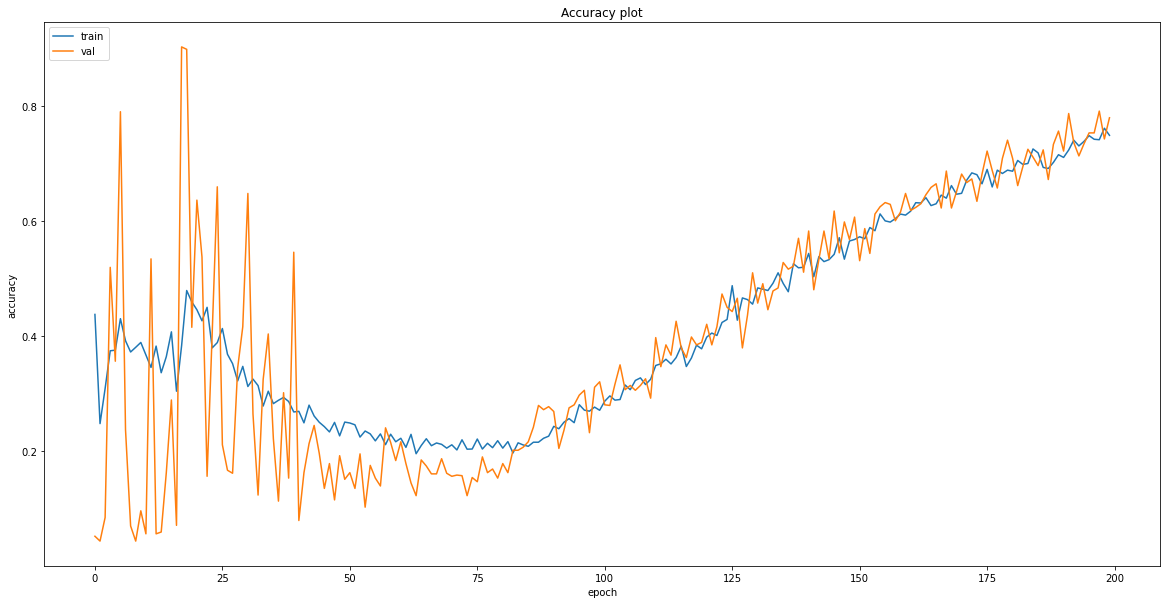

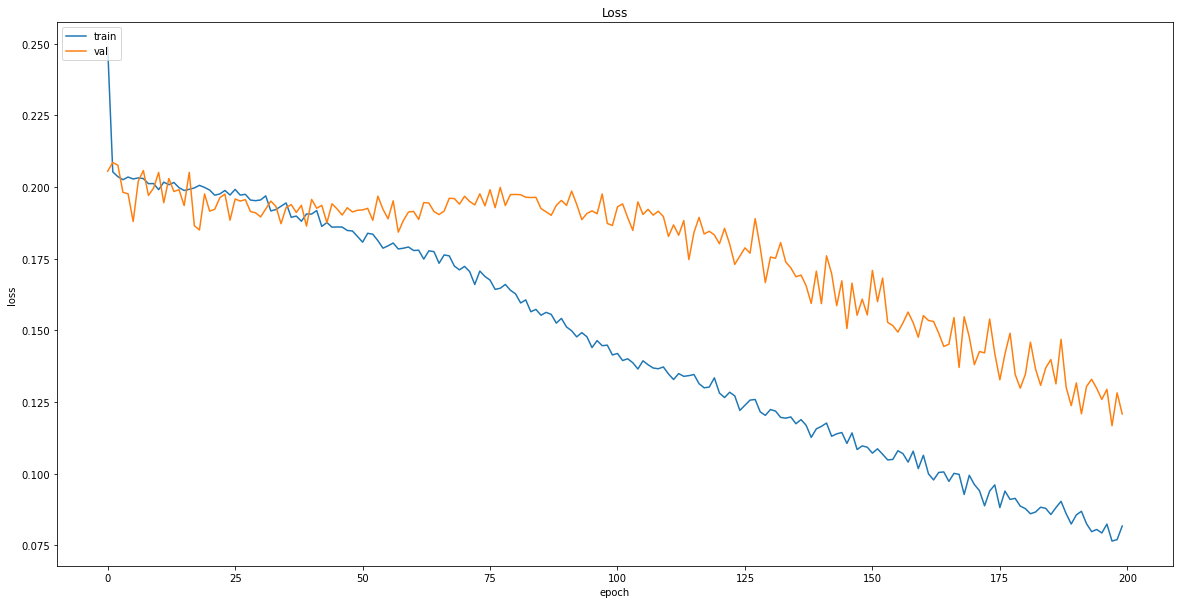

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [210]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [211]:
logger = []

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [213]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [215]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [216]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [217]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1247 - accuracy: 0.7706 - mean_squared_error: 2.3654 - weighted_accuracy: 0.7706 - weighted_mean_squared_error: 2.3654
Test loss: 0.1246877908706665
Test accuracy: 0.7706422209739685


In [218]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 8, 2: 181, 0: 29})

In [219]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [220]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [221]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

In [222]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

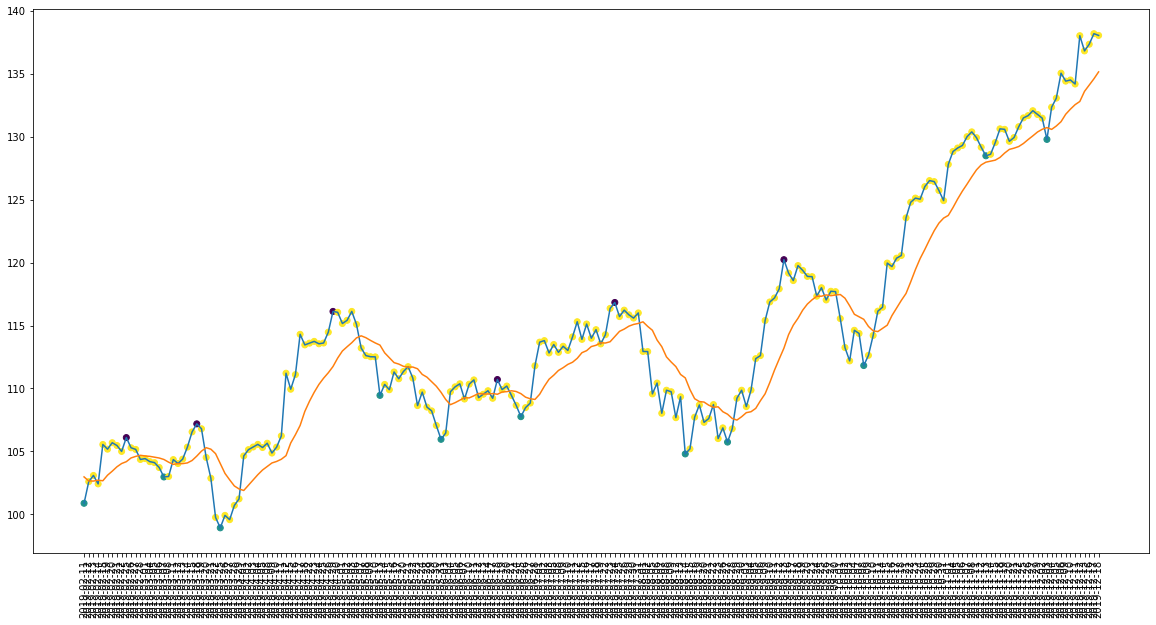

In [223]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [224]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 7
actual holds but predicted sell: 28
actual predicted holds: 166
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 82.58706467661692%
actual buys: 11
actual sells: 6
actual holds: 201


In [225]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 62.5%
Percentage sells correct: 51.724137931034484%
Percentage holds correct: 85.0%


In [226]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 5.578024785052116%
Share price: $106.8000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10524.19080815506


Share price: $99.76000213623048
Shares owned at the moment: 105
Cash capital at the moment: $20.584883234021618


Price increase from previously bought: 5.523758439515802%
Share price: $105.55999755859376
Shares owned at the moment: 0
Cash capital at the moment: $11073.904177591323


Share price: $108.22000122070312
Shares owned at the moment: 102
Cash capital at the moment: $5.108342737195926


Price increase from previously bought: 6.756868774751257%
Share price: $115.8499984741211
Shares owned at the moment: 0
Cash capital at the moment: $11789.312262525556


Share price: $118.9000015258789
Shares owned at the moment: 98
Cash capital at the moment: $105.06856257819891


Stop Loss Activated!

Share price: $

In [227]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [228]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   
5       0.600939                30.0%                50.0%   
6       0.770642   9.090909090909092%  16.666666666666668%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   
5   62.17616580310881%               50.0%   39.53488372093023%   
6   82.58706467661692%               62.5%  51.724137931034484%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%  
5  82.17054263565892%  -13.142344483392279%   -41.56249103630067%  
6               85.0%    20.89916026805873%    35.77290673755644%

### recession

In [229]:
logger = []

In [230]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [231]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [232]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [233]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [234]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [235]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1093 - accuracy: 0.8219 - mean_squared_error: 2.3083 - weighted_accuracy: 0.8219 - weighted_mean_squared_error: 2.3083
Test loss: 0.10926059633493423
Test accuracy: 0.8219178318977356


In [236]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 1: 4, 0: 24})

In [237]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [238]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [239]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

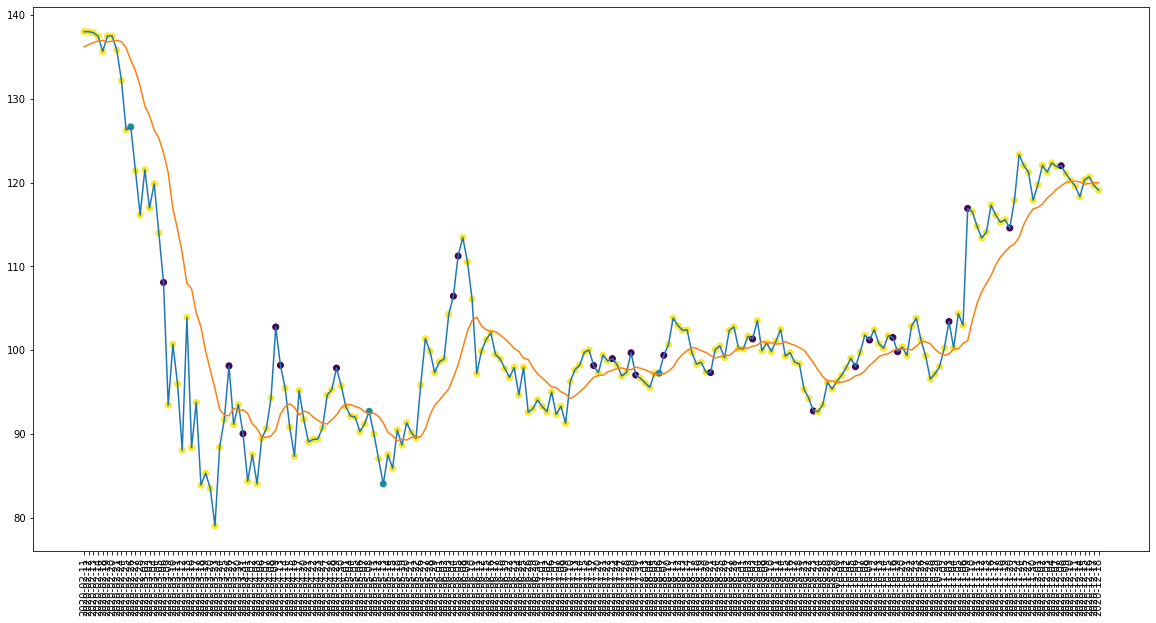

In [240]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

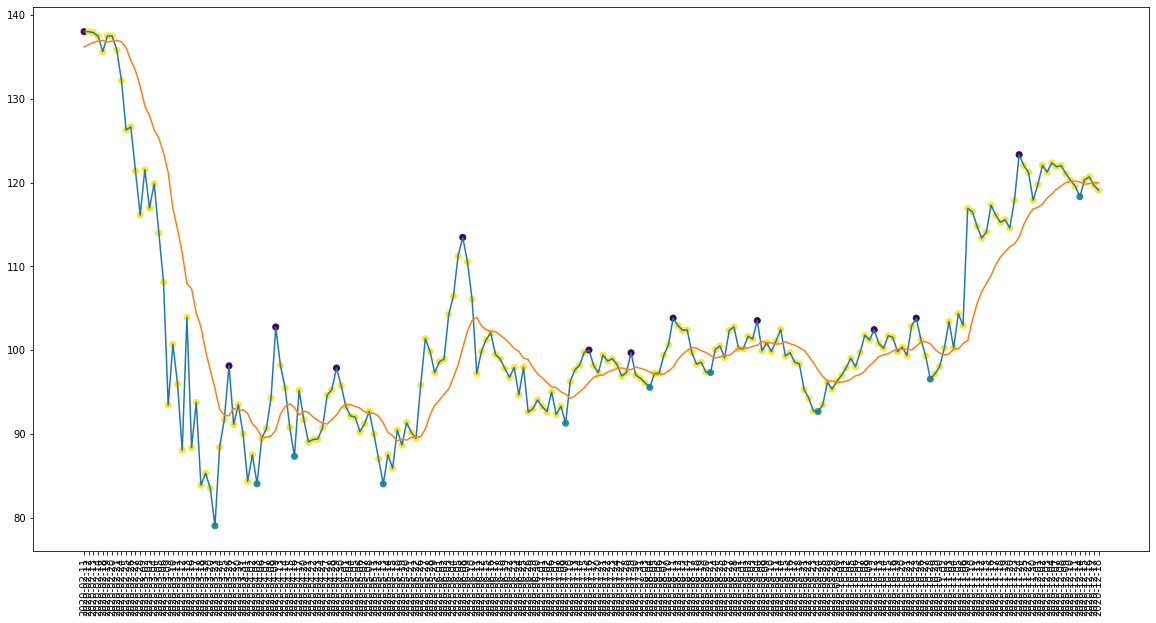

In [241]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [242]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 3
actual holds but predicted sell: 19
actual predicted holds: 175
Percentage buys correct: 10.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 88.83248730964468%
actual buys: 10
actual sells: 12
actual holds: 197


In [243]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 25.0%
Percentage sells correct: 58.333333333333336%
Percentage holds correct: 84.73684210526316%


In [244]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.63999938964844
Shares owned at the moment: 78
Cash capital at the moment: $94.91576773834277


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9535.7421163826


Share price: $92.6999969482422
Shares owned at the moment: 102
Cash capital at the moment: $54.34007851791284


Stop Loss Activated!

Share price: $89.97000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9206.043617687224


Share price: $84.02999877929688
Shares owned at the moment: 109
Cash capital at the moment: $21.585758609769982


Price increase from previously bought: 26.32166693047091%
Share price: $106.44000244140624
Shares owned at the moment: 0
Cash capital at the moment: $11591.640633991237


Share price: $97.23999786376952
Shares owned at the moment: 118
Cash capital at the moment: $85.76650675964083


Stop Loss Activated!

Share price: $94.2699966430664
Shares owned at the moment: 0
Cash capital at the moment: $

In [245]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [246]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   
5       0.600939                30.0%                50.0%   
6       0.770642   9.090909090909092%  16.666666666666668%   
7       0.821918                10.0%  33.333333333333336%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   
5   62.17616580310881%               50.0%   39.53488372093023%   
6   82.58706467661692%               62.5%  51.724137931034484%   
7   88.83248730964468%               25.0%  58.333333333333336%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%  
5  82.17054263565892%  -13.142344483392279%   -41.56249103630067%  
6               85.0%    20.89916026805873%    35.77290673755644%  
7  84.73684210526316%   11.790354967308012%   -14.13141708526613%

## American Axle & Manufacturing Holdings, Inc

In [247]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


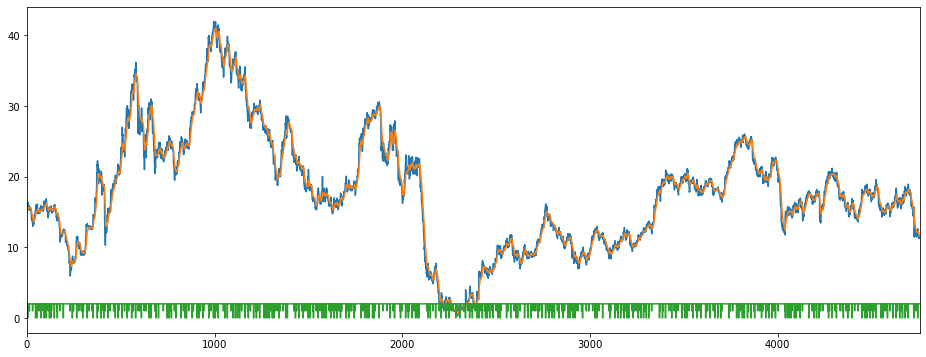

In [248]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [249]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [250]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [252]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

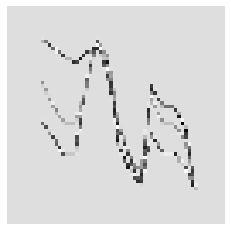

In [253]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [254]:
X = X/255

In [255]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [256]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [257]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [258]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [259]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}
Epoch 1/200
30/30 [==============================] - 2s 76ms/step - loss: 0.2448 - accuracy: 0.3936 - mse: 1.5973 - weighted_accuracy: 0.3287 - weighted_mse: 1.6710 - val_loss: 0.2177 - val_accuracy: 0.0548 - val_mse: 0.9522 - val_weighted_accuracy: 0.0548 - val_weighted_mse: 0.9522
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2049 - accuracy: 0.4117 - mse: 1.1798 - weighted_accuracy: 0.3373 - weighted_mse: 1.1970 - val_loss: 0.2030 - val_accuracy: 0.0506 - val_mse: 0.8096 - val_weighted_accuracy: 0.0506 - val_weighted_mse: 0.8096
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2048 - accuracy: 0.3799 - mse: 1.1415 - weighted_accuracy: 0.3057 - weighted_mse: 1.1639 - val_loss: 0.2007 - val_accuracy: 0.0917 - val_mse: 0.9249 - val_weighted_accuracy: 0.0917 - val_weighted_mse: 0.9249
Epoch 4/200
30/30 [==============================] - 0s 15ms/step - loss: 0.20

30/30 [==============================] - 0s 14ms/step - loss: 0.1961 - accuracy: 0.2463 - mse: 1.2118 - weighted_accuracy: 0.3731 - weighted_mse: 1.1898 - val_loss: 0.2013 - val_accuracy: 0.0685 - val_mse: 0.9638 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 0.9638
Epoch 29/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1934 - accuracy: 0.2545 - mse: 1.2057 - weighted_accuracy: 0.4052 - weighted_mse: 1.1936 - val_loss: 0.1938 - val_accuracy: 0.1159 - val_mse: 0.9861 - val_weighted_accuracy: 0.1159 - val_weighted_mse: 0.9861
Epoch 30/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1944 - accuracy: 0.2489 - mse: 1.2036 - weighted_accuracy: 0.3996 - weighted_mse: 1.1952 - val_loss: 0.1987 - val_accuracy: 0.0727 - val_mse: 0.9825 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9825
Epoch 31/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1943 - accuracy: 0.2790 - mse: 1.2143 - weighted_accuracy: 0.3960 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1810 - accuracy: 0.1459 - mse: 1.2760 - weighted_accuracy: 0.5006 - weighted_mse: 1.2389 - val_loss: 0.1963 - val_accuracy: 0.0896 - val_mse: 1.1826 - val_weighted_accuracy: 0.0896 - val_weighted_mse: 1.1826
Epoch 58/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1805 - accuracy: 0.1520 - mse: 1.2933 - weighted_accuracy: 0.5101 - weighted_mse: 1.2522 - val_loss: 0.1978 - val_accuracy: 0.0864 - val_mse: 1.0981 - val_weighted_accuracy: 0.0864 - val_weighted_mse: 1.0981
Epoch 59/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1791 - accuracy: 0.1370 - mse: 1.2980 - weighted_accuracy: 0.4972 - weighted_mse: 1.2551 - val_loss: 0.1976 - val_accuracy: 0.0769 - val_mse: 1.1601 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.1601
Epoch 60/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1763 - accuracy: 0.1573 - mse: 1.3620 - weighted_accuracy: 0.5212 - 

Epoch 86/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1574 - accuracy: 0.2089 - mse: 1.5145 - weighted_accuracy: 0.6257 - weighted_mse: 1.4700 - val_loss: 0.1968 - val_accuracy: 0.1834 - val_mse: 1.2548 - val_weighted_accuracy: 0.1834 - val_weighted_mse: 1.2548
Epoch 87/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1543 - accuracy: 0.1963 - mse: 1.5135 - weighted_accuracy: 0.6212 - weighted_mse: 1.4822 - val_loss: 0.1952 - val_accuracy: 0.2255 - val_mse: 1.4187 - val_weighted_accuracy: 0.2255 - val_weighted_mse: 1.4187
Epoch 88/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1561 - accuracy: 0.1949 - mse: 1.5424 - weighted_accuracy: 0.6171 - weighted_mse: 1.4823 - val_loss: 0.1953 - val_accuracy: 0.2160 - val_mse: 1.3688 - val_weighted_accuracy: 0.2160 - val_weighted_mse: 1.3688
Epoch 89/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1570 - accuracy: 0.2042 - mse: 1.4909 - weighted_accuracy: 0.6149 - 

Epoch 115/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1385 - accuracy: 0.2993 - mse: 1.7851 - weighted_accuracy: 0.6973 - weighted_mse: 1.8183 - val_loss: 0.1954 - val_accuracy: 0.2950 - val_mse: 1.5994 - val_weighted_accuracy: 0.2950 - val_weighted_mse: 1.5994
Epoch 116/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1371 - accuracy: 0.3074 - mse: 1.7715 - weighted_accuracy: 0.6930 - weighted_mse: 1.8483 - val_loss: 0.1939 - val_accuracy: 0.2824 - val_mse: 1.5830 - val_weighted_accuracy: 0.2824 - val_weighted_mse: 1.5830
Epoch 117/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1408 - accuracy: 0.3011 - mse: 1.7259 - weighted_accuracy: 0.6743 - weighted_mse: 1.7681 - val_loss: 0.1934 - val_accuracy: 0.3172 - val_mse: 1.6237 - val_weighted_accuracy: 0.3172 - val_weighted_mse: 1.6237
Epoch 118/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1369 - accuracy: 0.3222 - mse: 1.8547 - weighted_accuracy: 0.702

Epoch 144/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1235 - accuracy: 0.4415 - mse: 2.1716 - weighted_accuracy: 0.7640 - weighted_mse: 2.4119 - val_loss: 0.1801 - val_accuracy: 0.4489 - val_mse: 1.9107 - val_weighted_accuracy: 0.4489 - val_weighted_mse: 1.9107
Epoch 145/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1248 - accuracy: 0.4110 - mse: 2.1560 - weighted_accuracy: 0.7401 - weighted_mse: 2.4213 - val_loss: 0.1878 - val_accuracy: 0.3930 - val_mse: 1.8880 - val_weighted_accuracy: 0.3930 - val_weighted_mse: 1.8880
Epoch 146/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1217 - accuracy: 0.4389 - mse: 2.1495 - weighted_accuracy: 0.7631 - weighted_mse: 2.5240 - val_loss: 0.1819 - val_accuracy: 0.4299 - val_mse: 1.8827 - val_weighted_accuracy: 0.4299 - val_weighted_mse: 1.8827
Epoch 147/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1228 - accuracy: 0.4339 - mse: 2.2265 - weighted_accuracy: 0.750

Epoch 173/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1100 - accuracy: 0.5743 - mse: 2.6855 - weighted_accuracy: 0.7982 - weighted_mse: 3.4026 - val_loss: 0.1566 - val_accuracy: 0.6417 - val_mse: 2.4843 - val_weighted_accuracy: 0.6417 - val_weighted_mse: 2.4843
Epoch 174/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1085 - accuracy: 0.5635 - mse: 2.8461 - weighted_accuracy: 0.8051 - weighted_mse: 3.7003 - val_loss: 0.1643 - val_accuracy: 0.5732 - val_mse: 2.2788 - val_weighted_accuracy: 0.5732 - val_weighted_mse: 2.2788
Epoch 175/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1082 - accuracy: 0.5761 - mse: 2.7276 - weighted_accuracy: 0.8098 - weighted_mse: 3.5387 - val_loss: 0.1606 - val_accuracy: 0.5985 - val_mse: 2.3388 - val_weighted_accuracy: 0.5985 - val_weighted_mse: 2.3388
Epoch 176/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1094 - accuracy: 0.5788 - mse: 2.8043 - weighted_accuracy: 0.810

In [260]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.14157573878765106
Test accuracy: 0.6891464591026306


In [261]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.7879937  -0.54440975 -0.35252845]
 [-1.0558435  -1.5490558  -0.21675432]
 [-3.315263    0.16346693 -0.71035415]
 ...
 [-2.1465187  -1.0583053  -0.17208178]
 [-0.34299752 -2.5791671  -0.51426744]
 [-1.9722615  -1.2375517  -0.16269206]]


Counter({2: 691, 1: 141, 0: 117})

In [262]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [263]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 16
actual buys but predicted sell: 2
actual buys but predicted hold: 26
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 123
actual holds but predicted sell: 108
actual predicted holds: 631
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 73.20185614849188%
actual buys: 44
actual sells: 43
actual holds: 862


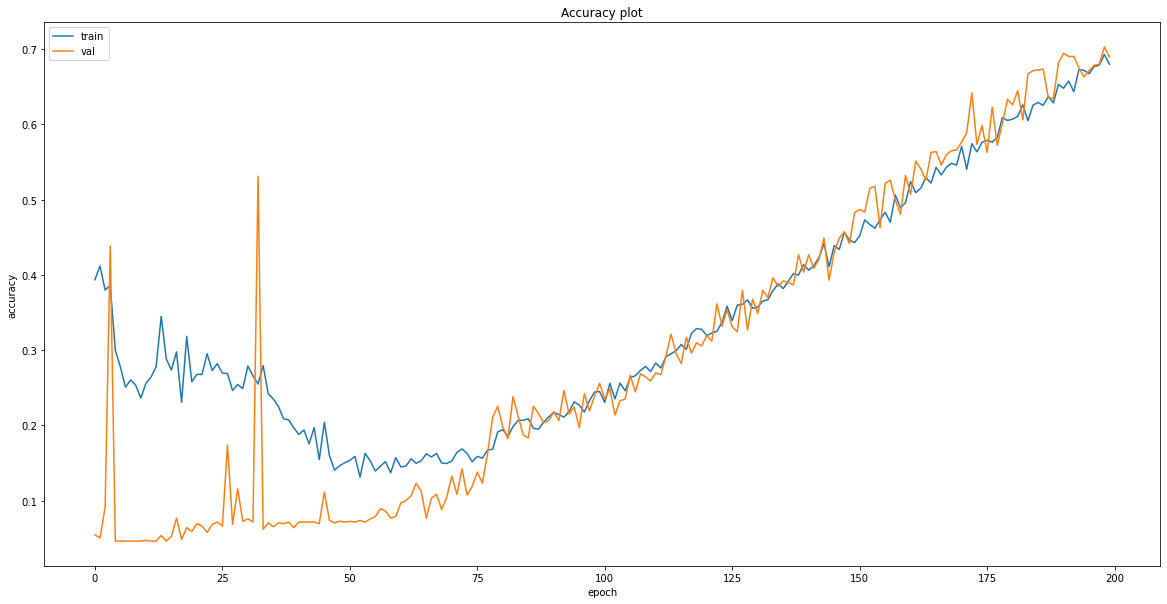

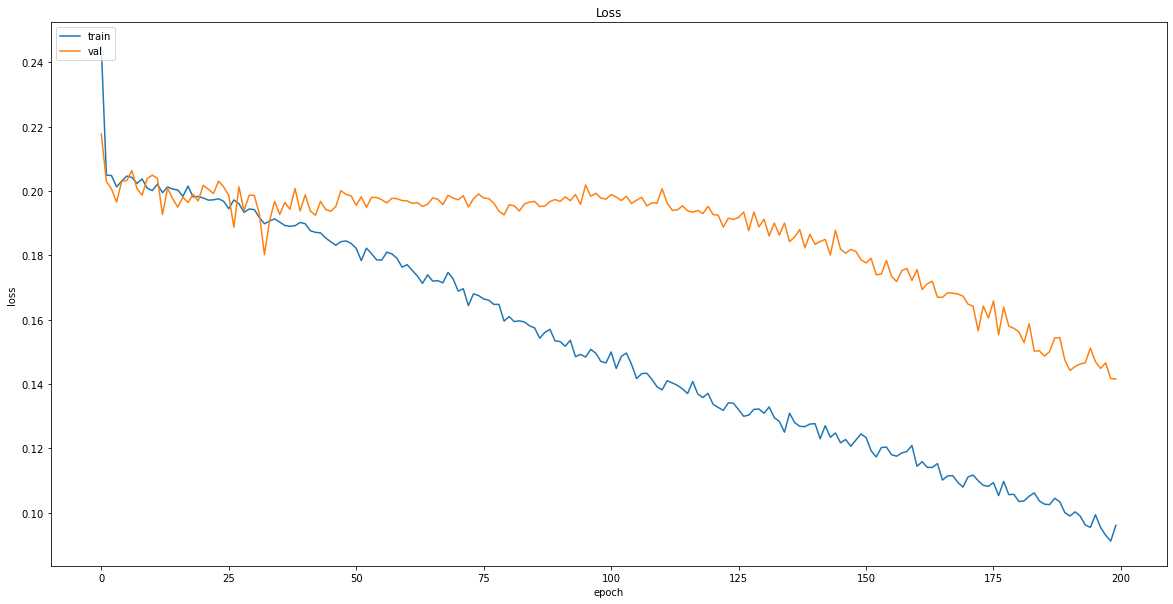

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [265]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [266]:
logger = []

In [267]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [268]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [269]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [270]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [271]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [272]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.6927 - mean_squared_error: 2.7159 - weighted_accuracy: 0.6927 - weighted_mean_squared_error: 2.7159
Test loss: 0.1430685818195343
Test accuracy: 0.6926605701446533


In [273]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 31, 2: 160, 0: 27})

In [274]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [275]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [276]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       2  
2019-02-12            1       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

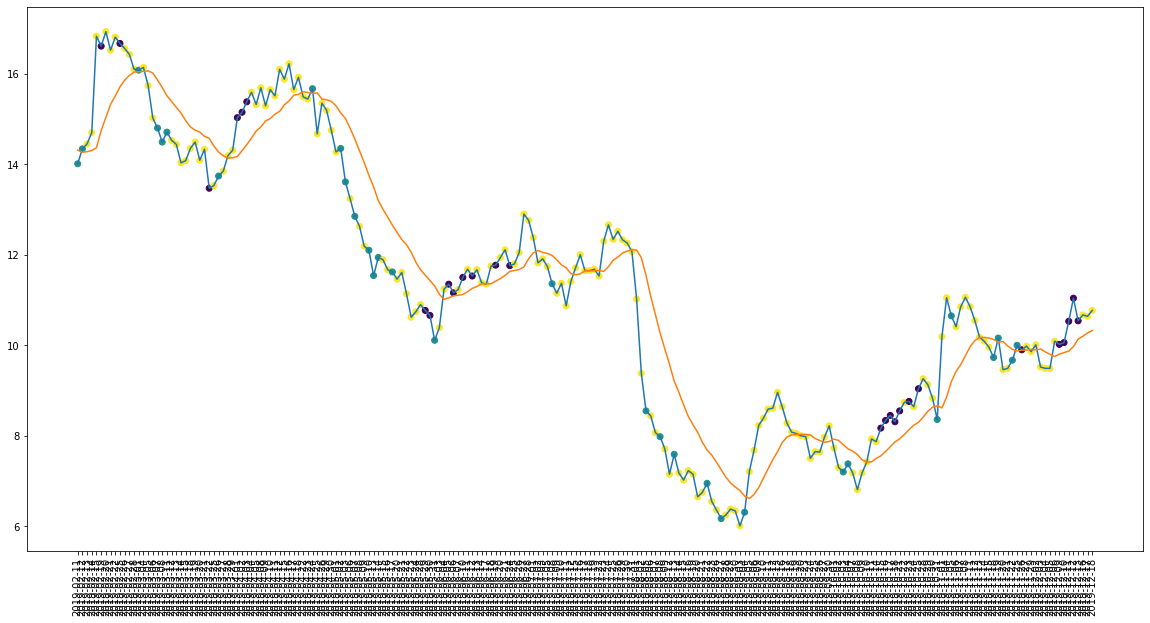

In [277]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

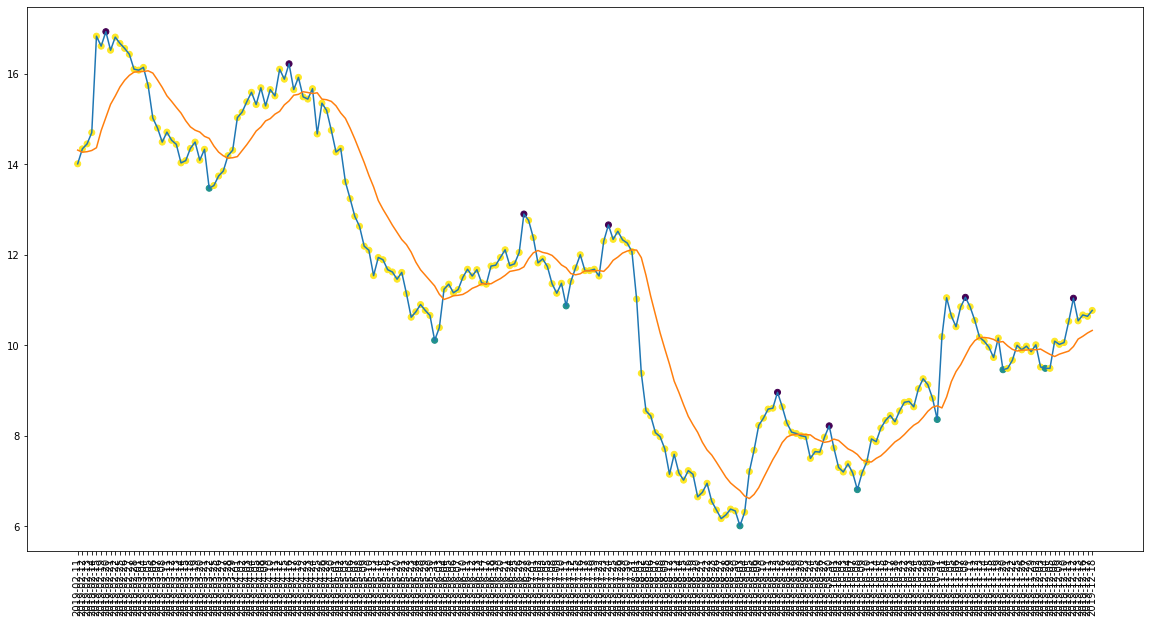

In [278]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [279]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 29
actual holds but predicted sell: 25
actual predicted holds: 148
Percentage buys correct: 25.0%
Percentage sells correct: 12.5%
Percentage holds correct: 73.26732673267327%
actual buys: 8
actual sells: 8
actual holds: 202


In [280]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 45.16129032258065%
Percentage sells correct: 48.148148148148145%
Percentage holds correct: 84.90566037735849%


In [281]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 18.233034309065022%
Share price: $16.610000610351562
Shares owned at the moment: 0
Cash capital at the moment: $11788.730514584064


Share price: $16.079999923706055
Shares owned at the moment: 731
Cash capital at the moment: $1.9257505083078286


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10951.352129213332


Share price: $14.800000190734865
Shares owned at the moment: 737
Cash capital at the moment: $13.756088255164286


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10325.430589496134


Share price: $13.739999771118164
Shares owned at the moment: 749
Cash capital at the moment: $5.86979640006939


Price increase from previously bought: 9.08865237294625%
Share price: $15.029999732971193
Shares own

In [282]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [283]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   
5       0.600939                30.0%                50.0%   
6       0.770642   9.090909090909092%  16.666666666666668%   
7       0.821918                10.0%  33.333333333333336%   
8       0.692661                25.0%                12.5%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   
5   62.17616580310881%               50.0%   39.53488372093023%   
6   82.58706467661692%               62.5%  51.724137931034484%   
7   88.83248730964468%               25.0%  58.333333333333336%   
8   73.26732673267327%  45.16129032258065%  48.148148148148145%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%  
5  82.17054263565892%  -13.142344483392279%   -41.56249103630067%  
6               85.0%    20.89916026805873%    35.77290673755644%  
7  84.73684210526316%   11.790354967308012%   -14.13141708526613%  
8  84.90566037735849%   4.3133377326701705%  -23.520909336075793%

### recession

In [284]:
logger = []

In [285]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [286]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
# data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        # data_15_ema_arr = min_max_scaler.fit_transform(# data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(# data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        # data_15_ema = # data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        # data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [288]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [289]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [290]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.7123 - mean_squared_error: 2.7609 - weighted_accuracy: 0.7123 - weighted_mean_squared_error: 2.7609
Test loss: 0.13847491145133972
Test accuracy: 0.7123287916183472


In [291]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 1: 27, 0: 25})

In [292]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [293]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [294]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            2   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            2   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

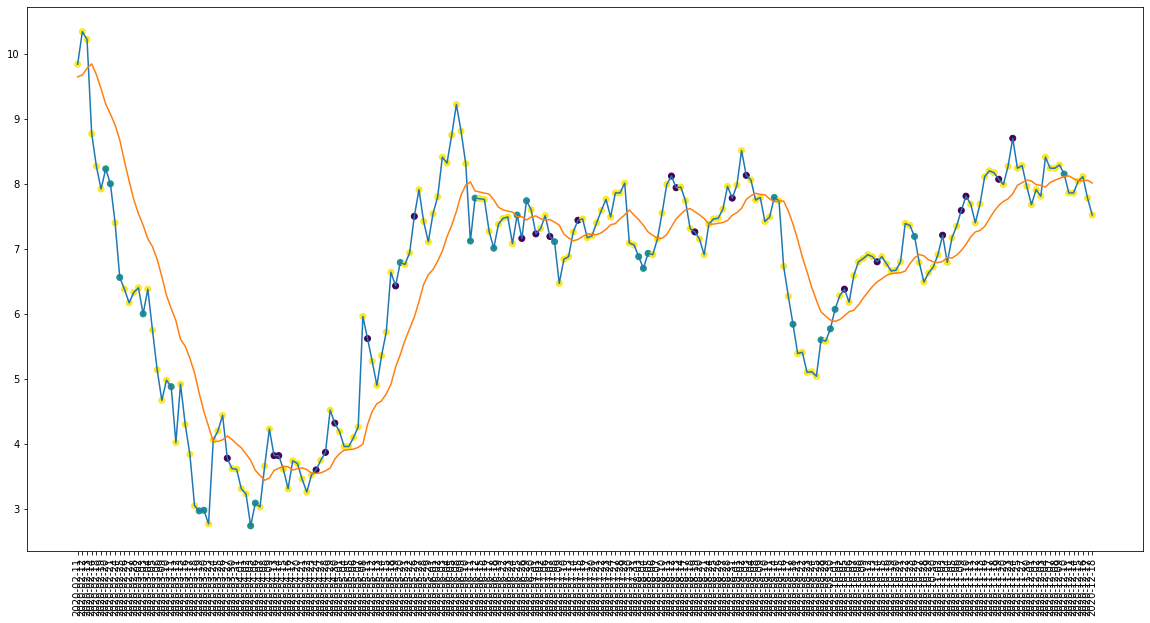

In [295]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

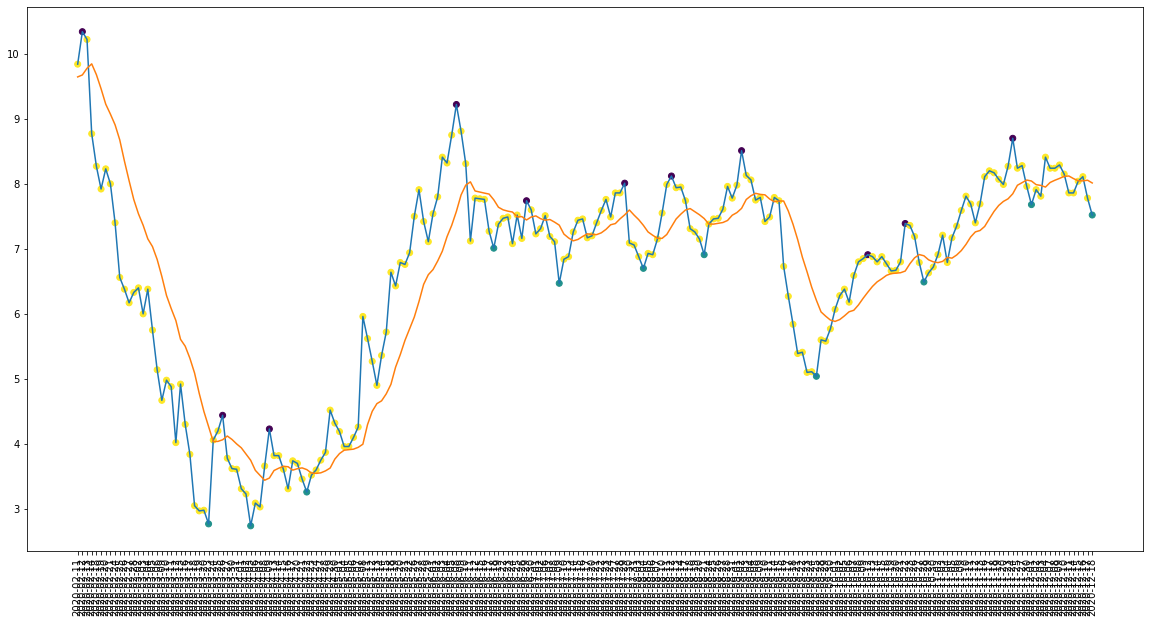

In [296]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [297]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 23
actual predicted holds: 151
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 76.6497461928934%
actual buys: 11
actual sells: 11
actual holds: 197


In [298]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 42.30769230769231%
Percentage sells correct: 60.0%
Percentage holds correct: 85.02994011976048%


In [299]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $8.0
Shares owned at the moment: 1205
Cash capital at the moment: $0.9105983762747201


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $8893.388962978006


Share price: $6.559999942779541
Shares owned at the moment: 1351
Cash capital at the moment: $6.457000495434841


Stop Loss Activated!

Share price: $6.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $8602.133859679938


Share price: $6.0
Shares owned at the moment: 1429
Cash capital at the moment: $4.555359679938192


Stop Loss Activated!

Share price: $5.75
Shares owned at the moment: 0
Cash capital at the moment: $8198.709297179937


Share price: $4.880000114440918
Shares owned at the moment: 1675
C

In [300]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [301]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.729358  33.333333333333336%  33.333333333333336%   
1       0.693023                37.5%  33.333333333333336%   
2       0.683486                 0.0%   22.22222222222222%   
3       0.683721   8.333333333333334%                30.0%   
4       0.601896                37.5%   44.44444444444444%   
5       0.600939                30.0%                50.0%   
6       0.770642   9.090909090909092%  16.666666666666668%   
7       0.821918                10.0%  33.333333333333336%   
8       0.692661                25.0%                12.5%   
9       0.712329  27.272727272727273%  18.181818181818183%   

         correct_holds    correct_low_buys   correct_high_sells  \
0                76.5%  52.77777777777778%    58.8235294117647%   
1   72.22222222222223%  41.46341463414634%                65.0%   
2   73.13432835820896%               55.0%   55.55555555555556%   
3   74.09326424870466%   63.1578947368421%  63.888888888888886%   
4  61.855670103092784%  52.38095238095238%   53.65853658536585%   
5   62.17616580310881%               50.0%   39.53488372093023%   
6   82.58706467661692%               62.5%  51.724137931034484%   
7   88.83248730964468%               25.0%  58.333333333333336%   
8   73.26732673267327%  45.16129032258065%  48.148148148148145%   
9    76.6497461928934%  42.30769230769231%                60.0%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0   79.8780487804878%   -8.694745558424039%    -7.30802773938658%  
1  86.27450980392157%   3.6776627059422937%  -48.998182398364555%  
2    84.472049689441%    2.848248274831749%   -5.545324129943856%  
3  86.16352201257861%  -6.4416370695948535%   -7.669883276367181%  
4  81.10236220472441%  -23.550635138907612%  -10.879329186439518%  
5  82.17054263565892%  -13.142344483392279%   -41.56249103630067%  
6               85.0%    20.89916026805873%    35.77290673755644%  
7  84.73684210526316%   11.790354967308012%   -14.13141708526613%  
8  84.90566037735849%   4.3133377326701705%  -23.520909336075793%  
9  85.02994011976048%  -18.988334869270947%   -23.98520794264914%

In [302]:
experiment

'No EMA CNN Images Experiments - cyclic'

In [303]:
log.to_csv('{}.csv'.format(experiment))